# FINM 35000 Problem Set 3: Equity Valuation Stress Testing

<span style="color:blue">Aman Krishna </span> <br>
<br>
<span style="color:#406A5F">Tim Taylor </span> <br>
<br>
<span style="color:purple">Yazmin Ramirez Delgado </span>

In [523]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math as m 
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
from scipy.stats import norm
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', '{:.3f}'.format)
warnings.filterwarnings("ignore")

## Stress testing an equity portfolio (100 points)

Project market value changes of an equity portfolio from time0 to time1 based on the changes in the macroeconomic variables (MEVs) from the severely adverse economic domestic scenario of the Federal Reserve’s Comprehensive Capital Analysis and Review (CCAR) 2021. Time0 is 12/31/2020 and time1 is 12/31/2021.

To make the projections, you may need to map the changes of MEVs from time0 to time1 to the change in values of the stocks from time0 to time1. In addition to the scenario given above,

    - Investment instruments: a portfolio of 20 stocks, 10 million shares in each stock.
    - Additional scenarios and historical data of the MEVs in the Fed scenarios. The Federal Reserve also provide scenario description narratives.
    - Equity and Fama-French factor historical data (total returns), ‘returns’ tab in wrds_data.xlsx

## 1. Build three projection models then compare the approaches and project the changes in the portfolio’s value: CAPM, Fama-French, and a “general multi-factor” model. You are required to provide support for your modeling choices where applicable (segmentation3, variable selection, choice(s) of historical data window, etc.). Your report should provide a clear picture of the modeling development process and modeling choices:


   1. i. Outline your steps in developing each model.
   2. ii. Describe your data processing procedures for missing data, data quality and if any, variable transformation. Provide justification if it’s necessary to use data outside of the data files from the assignment and the data files underlying the links in this document.
   3. iii. Demonstrate your variable selection process in each model supported by economic reasoning based on your understanding in the MEVs.
   4. iv. State the data window for each of your regression model. Perform your regressions using two data sets as if you were doing this homework twice- data from all times and data from only the “stressed times”,4 or else? How do different data choices affect your regression coefficients and forecasts?
   5. v. Define and support the granularity of your modeling. You can model and make projections at the individual stock level, or at the segment level (e.g., industry groups, or by stock style (growth versus value), etc.), or at the portfolio level.
   6. vi. If model at the segment or portfolio level, you may need to construct a synthetic time series for the segment or portfolio returns. The total returndata of each stock goes back to as far as 1963. However, the market weight data of each stock does not go back that far (see ‘prices’ tab in wrds_data.xlsx). Use judgment or arbitrarily assign weights when constructing the synthetic portfolio total return time series.
   7. vii. Provide rationale for your selection(s) of the equity market variable, the MEVs, and the time window of historical data used in the regressions. For example, the data file, wrds_data.xlsx (‘returns’ tab), contains historical equity and market data for CAPM and Fama-French. The Fed historical data also contains equity market data. (Hint: You may need to choose an equity market index from different sources)
   8. viii. Perform stationarity test(s) on the MEVs and transform the data if necessary and, in your own words, discuss stationarity testing is necessary in your modeling process.
   9. ix. In the stress test, you will need to build a two-step regression for the 3-factor Fama-French model. In the first step, regress Fama-French factors as functions of the MEVs in the Fed scenario. In the second step, combine your regressions into the Fama-French model and project the time1 portfolio value in the scenario.
   10. x. The general multi-factor model (GMF): Model the equity portfolio’s scenariovalues directly as a function of the MEVs provided in the Fed scenario and project the time1 portfolio value in the scenario.
   11. xi. Conduct performance testing for each model. You may need to use thesetests to guide yourself to go through an iterative process to improve model performance:
       1.  • Goodness of fit.
       2.  • Residual analysis.
       3.  • At least one more test to support the robustness of your models.
   12. xii. Finally the forecast portion in your report should contain a summary of projection outcomes (%return and $value change) from the three modeling approaches (i.e., CAPM, Fama French, and GMF).

>Given the observed data, we are going to separate the models in the following way:
>
>For CAPM and FAMA FRENCH, we are going to use monthly returns data since the data is available at that frequency
>
>On the other hand for the models using MEVs, we are going to use quarterly frequency as per data availability.

In [524]:
# Load the data
wrds_price_data = pd.read_excel('wrds_data-1.xlsx', sheet_name='prices')
wrds_price_data['Date'] = pd.to_datetime(wrds_price_data['Date'], format='%Y-%m')
wrds_price_data.set_index('Date', inplace=True)
#Drop "High Price" and "Low Price" columns
wrds_price_data.drop(['High Price', 'Low Price', 'Company Name'], axis=1, inplace=True)

# Pivot the DataFrame
wrds_price_data_pivot = wrds_price_data.pivot(columns='Ticker', values='Close Price')
wrds_price_data_pivot.head()

Ticker,ADM,BAC,BIIB,C,CAG,CCL,CL,CPB,DRI,GS,...,KO,LLY,MAR,MRK,MS,PFE,PG,SBUX,TSN,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,35.350,14.140,273.060,42.580,41.640,48.130,67.530,56.410,63.060,161.560,...,42.920,79.100,61.280,50.670,25.880,30.490,81.690,60.770,53.360,66.360
2016-02-01,34.960,12.520,259.420,38.850,42.060,47.960,65.640,61.750,63.880,149.530,...,43.130,72.000,68.150,50.210,24.700,29.670,80.290,58.210,64.750,66.340
2016-03-01,36.310,13.520,260.320,41.750,44.620,52.770,70.650,63.790,66.300,156.980,...,46.390,72.010,71.180,52.910,25.010,29.640,82.310,59.700,66.660,68.490
2016-04-01,39.940,14.560,274.990,46.280,44.560,49.050,70.920,61.710,62.250,164.110,...,44.800,75.530,70.090,54.840,27.060,32.710,80.120,56.230,65.820,66.870
2016-05-01,42.770,14.790,289.730,46.570,45.700,47.740,70.410,60.570,67.830,159.480,...,44.600,75.030,66.040,56.260,27.370,34.700,81.040,54.890,63.780,70.780


In [525]:
# Load the data
wrds_data = pd.read_excel('wrds_data-1.xlsx', sheet_name='returns')
#Change Date column fromth format "YYYY-MM" to datetime
wrds_data['Date'] = pd.to_datetime(wrds_data['Date'], format='%Y-%m')
#remove the columns after "WALMART INC"
wrds_data = wrds_data.iloc[:,0:28]

#Calculate excess return for each stock starting column 8. The risk free rate is in column 4
wrds_data.iloc[:,8:] = wrds_data.iloc[:,8:].sub(wrds_data.iloc[:,4], axis=0)

#Resample the data to quarterly with the first day of the quarter as the date
wrds_data_q = wrds_data.set_index('Date').resample('QS').first().reset_index()
wrds_data_q.head()

,Date,MKT COMPOSITE RETURN,S&P RETURN,FAMA-FRENCH MARKET FACTOR,RISK-FREE RATE,FAMA-FRENCH SIZE FACTOR (SMB),FAMA-FRENCH VALUE FACTOR (HML),MOMENTUM FACTOR,BIOGEN INC,JOHNSON & JOHNSON,...,ARCHER-DANIELS-MIDLAND CO,CONAGRA BRANDS INC,COLGATE-PALMOLIVE CO,CAMPBELL SOUP CO,KELLOGG CO,KRAFT HEINZ CO,COCA-COLA CO,PROCTER & GAMBLE CO,TYSON FOODS INC -CL A,WALMART INC
0,1963-01-01,NaN,0.049,0.049,0.003,0.031,0.022,-0.021,NaN,0.100,...,NaN,NaN,0.070,0.091,0.149,NaN,0.056,0.031,NaN,NaN
1,1963-04-01,NaN,0.049,0.045,0.003,-0.013,0.010,-0.001,NaN,0.009,...,NaN,NaN,0.043,0.001,-0.055,NaN,-0.013,0.054,NaN,NaN
2,1963-07-01,NaN,-0.004,-0.004,0.003,-0.005,-0.009,0.010,NaN,-0.005,...,NaN,NaN,-0.003,0.036,0.062,NaN,0.016,-0.030,NaN,NaN
3,1963-10-01,NaN,0.032,0.025,0.003,-0.006,-0.000,0.031,NaN,0.157,...,NaN,NaN,-0.088,0.013,0.070,NaN,0.012,0.005,NaN,NaN
4,1964-01-01,NaN,0.027,0.022,0.003,-0.002,0.015,0.011,NaN,0.029,...,NaN,NaN,-0.038,-0.028,-0.026,NaN,0.019,0.031,NaN,NaN


>We are creating a map between the ticker and stock names

In [526]:
#Read the wrds_data file and create a map to tickers
wrds_ticker = pd.read_excel('wrds_data-1.xlsx', sheet_name='returns')
wrds_ticker = wrds_ticker.iloc[:,30:].dropna()
#drop 2nd column
wrds_ticker = wrds_ticker.drop(wrds_ticker.columns[1], axis=1)
#Rename 'ELI LILLY & CO' to 'LILLY (ELI) & CO'
wrds_ticker = wrds_ticker.replace({'ELI LILLY & CO':'LILLY (ELI) & CO'})
#Rename 'MERCK & CO. INC.' to 'MERCK & CO'
wrds_ticker = wrds_ticker.replace({'MERCK & CO. INC.':'MERCK & CO'})
#Rename 'KRAFT HEINZ CO/THE' to 'KRAFT HEINZ CO'
wrds_ticker = wrds_ticker.replace({'KRAFT HEINZ CO/THE':'KRAFT HEINZ CO'})
#Rename 'COCA-COLA CO/THE' to 'COCA-COLA CO'
wrds_ticker = wrds_ticker.replace({'COCA-COLA CO/THE':'COCA-COLA CO'})
#Rename 'PROCTER & GAMBLE CO/THE' to 'PROCTER & GAMBLE CO'
wrds_ticker = wrds_ticker.replace({'PROCTER & GAMBLE CO/THE':'PROCTER & GAMBLE CO'})
#Rename 'TYSON FOODS INC-CL A' to 'TYSON FOODS INC  -CL A'
wrds_ticker = wrds_ticker.replace({'TYSON FOODS INC-CL A':'TYSON FOODS INC  -CL A'})
#Create  dictionary with Name as key and Ticker as value
wrds_ticker = wrds_ticker.set_index('Name').to_dict()['Ticker']
wrds_ticker

{'BIOGEN INC': 'BIIB',
 'JOHNSON & JOHNSON': 'JNJ',
 'LILLY (ELI) & CO': 'LLY',
 'MERCK & CO': 'MRK',
 'PFIZER INC': 'PFE',
 'BANK OF AMERICA CORP': 'BAC',
 'CITIGROUP INC': 'C',
 'GOLDMAN SACHS GROUP INC': 'GS',
 'JPMORGAN CHASE & CO': 'JPM',
 'MORGAN STANLEY': 'MS',
 'ARCHER-DANIELS-MIDLAND CO': 'ADM',
 'CONAGRA BRANDS INC': 'CAG',
 'COLGATE-PALMOLIVE CO': 'CL',
 'CAMPBELL SOUP CO': 'CPB',
 'KELLOGG CO': 'K',
 'KRAFT HEINZ CO': 'KHC',
 'COCA-COLA CO': 'KO',
 'PROCTER & GAMBLE CO': 'PG',
 'TYSON FOODS INC  -CL A': 'TSN',
 'WALMART INC': 'WMT'}

In [527]:
for i in wrds_data.columns[8:]:
    #use the key to replace the column name
    wrds_data = wrds_data.rename(columns={i: wrds_ticker[i]})
    wrds_data_q = wrds_data_q.rename(columns={i: wrds_ticker[i]})
wrds_data.head()

,Date,MKT COMPOSITE RETURN,S&P RETURN,FAMA-FRENCH MARKET FACTOR,RISK-FREE RATE,FAMA-FRENCH SIZE FACTOR (SMB),FAMA-FRENCH VALUE FACTOR (HML),MOMENTUM FACTOR,BIIB,JNJ,...,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
0,1963-01-01,NaN,0.049,0.049,0.003,0.031,0.022,-0.021,NaN,0.100,...,NaN,NaN,0.070,0.091,0.149,NaN,0.056,0.031,NaN,NaN
1,1963-02-01,NaN,-0.029,-0.024,0.002,0.005,0.022,0.025,NaN,0.017,...,NaN,NaN,-0.002,-0.106,-0.062,NaN,-0.005,-0.033,NaN,NaN
2,1963-03-01,NaN,0.035,0.031,0.002,-0.026,0.021,0.016,NaN,0.001,...,NaN,NaN,0.070,0.010,0.097,NaN,0.044,0.040,NaN,NaN
3,1963-04-01,NaN,0.049,0.045,0.003,-0.013,0.010,-0.001,NaN,0.009,...,NaN,NaN,0.043,0.001,-0.055,NaN,-0.013,0.054,NaN,NaN
4,1963-05-01,NaN,0.014,0.018,0.002,0.011,0.025,0.004,NaN,0.049,...,NaN,NaN,0.008,0.019,0.096,NaN,0.003,-0.018,NaN,NaN


In [528]:
# Remove all the rows before 1999-06
wrds_data = wrds_data[wrds_data['Date'] >= '1999-06']
wrds_data_q = wrds_data_q[wrds_data_q['Date'] >= '1999-06']
wrds_data.reset_index(drop=True, inplace=True)
wrds_data_q.reset_index(drop=True, inplace=True)
wrds_data.head()

,Date,MKT COMPOSITE RETURN,S&P RETURN,FAMA-FRENCH MARKET FACTOR,RISK-FREE RATE,FAMA-FRENCH SIZE FACTOR (SMB),FAMA-FRENCH VALUE FACTOR (HML),MOMENTUM FACTOR,BIIB,JNJ,...,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
0,1999-06-01,0.042,0.054,0.048,0.004,0.032,-0.034,0.049,0.524,0.054,...,0.025,0.018,-0.018,0.044,-0.053,NaN,-0.097,-0.048,-0.026,0.129
1,1999-07-01,-0.034,-0.032,-0.035,0.004,0.025,-0.005,0.015,0.282,-0.075,...,-0.101,-0.037,0.002,-0.050,0.051,NaN,-0.027,0.015,-0.173,-0.128
2,1999-08-01,-0.022,-0.006,-0.014,0.004,-0.010,-0.017,0.029,0.278,0.122,...,-0.021,-0.045,0.080,0.000,0.025,NaN,-0.016,0.092,-0.142,0.045
3,1999-09-01,-0.032,-0.029,-0.028,0.004,0.034,-0.034,0.065,-0.264,-0.105,...,-0.071,-0.083,-0.149,-0.118,0.049,NaN,-0.194,-0.059,0.019,0.071
4,1999-10-01,0.055,0.062,0.061,0.004,-0.068,-0.032,0.055,0.232,0.136,...,0.006,0.151,0.322,0.152,0.059,NaN,0.219,0.118,-0.076,0.188


> We chose the June, 1999 date as the start of our dataset to take into account the data availability for the 20 equities provided in this exercise. On June, 1999 all but one (Kraft Heinz Co) have return data available.
> 
> Moreover >20 years of monthly data is a reasonable amount of data to use for our analysis.

In [529]:
#Backfill the missing values
wrds_data = wrds_data.fillna(method='bfill')
wrds_data_q = wrds_data_q.fillna(method='bfill')
wrds_data.head()

,Date,MKT COMPOSITE RETURN,S&P RETURN,FAMA-FRENCH MARKET FACTOR,RISK-FREE RATE,FAMA-FRENCH SIZE FACTOR (SMB),FAMA-FRENCH VALUE FACTOR (HML),MOMENTUM FACTOR,BIIB,JNJ,...,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
0,1999-06-01,0.042,0.054,0.048,0.004,0.032,-0.034,0.049,0.524,0.054,...,0.025,0.018,-0.018,0.044,-0.053,-0.086,-0.097,-0.048,-0.026,0.129
1,1999-07-01,-0.034,-0.032,-0.035,0.004,0.025,-0.005,0.015,0.282,-0.075,...,-0.101,-0.037,0.002,-0.050,0.051,-0.086,-0.027,0.015,-0.173,-0.128
2,1999-08-01,-0.022,-0.006,-0.014,0.004,-0.010,-0.017,0.029,0.278,0.122,...,-0.021,-0.045,0.080,0.000,0.025,-0.086,-0.016,0.092,-0.142,0.045
3,1999-09-01,-0.032,-0.029,-0.028,0.004,0.034,-0.034,0.065,-0.264,-0.105,...,-0.071,-0.083,-0.149,-0.118,0.049,-0.086,-0.194,-0.059,0.019,0.071
4,1999-10-01,0.055,0.062,0.061,0.004,-0.068,-0.032,0.055,0.232,0.136,...,0.006,0.151,0.322,0.152,0.059,-0.086,0.219,0.118,-0.076,0.188


Since one of the firms did not have data available for the entire period, we decided to backfill the data for the missing dates with the last available data point.

We will use the returns (which are LOG) to build our historical price series which will be used to make the weighted return series for the clustered porfolios.

In [530]:
# wrds_price_data_pivot which has prices for various tickers starts from 2016-01-01. we need to use the LOG returns from wrds_data to get the prices for the period 1999-06-01 to 2015-12-01. Note its monthly data (first day of each month)

#Create an empty price dataframe with columns as tickers and index as monthly dates (first day of each month)
wrds_price_monthly = pd.DataFrame(index=pd.date_range(start='1999-06-01', end='2020-12-01', freq='MS'), columns=wrds_data.columns[8:])

#Loop through each column (ticker) and get the price from wrds_price_data_pivot
for ticker in wrds_price_monthly.columns:
    wrds_price_monthly.loc['2016-01-01':'2020-12-01',ticker] = wrds_price_data_pivot.loc['2016-01-01':'2020-12-01',ticker].values

In [531]:
wrds_data.set_index('Date', inplace=True)
for ticker in wrds_price_monthly.columns:
    #Create start date as 
    start_date = wrds_price_monthly.index[len(wrds_price_monthly.loc['1999-06-01':'2015-12-01',:])]
    for i in range(0,len(wrds_price_monthly.loc['1999-06-01':'2015-12-01',:]),1):
        start_date = pd.Timestamp(start_date) - pd.DateOffset(months=1)
        start_date = start_date.strftime('%Y-%m-%d')
        start_date_fut = pd.Timestamp(start_date) + pd.DateOffset(months=1)
        start_date_fut = start_date_fut.strftime('%Y-%m-%d')
        wrds_price_monthly.loc[start_date, ticker] = wrds_price_monthly.loc[start_date_fut, ticker] / m.exp(wrds_data.loc[start_date_fut,ticker])

In [532]:
# Since we dont have Heinz return data before 2015-08-01, we will just back-fill it before that date
for dates in wrds_price_monthly.index:
    if dates < pd.Timestamp('2015-09-01'):
        wrds_price_monthly.loc[dates,'KHC'] = wrds_price_monthly.loc['2015-09-01','KHC']

In [533]:
wrds_price_monthly

,BIIB,JNJ,LLY,MRK,PFE,BAC,C,GS,JPM,MS,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
1999-06-01,2.721,34.073,33.836,29.801,20.263,7.006,62.096,33.498,20.178,13.410,6.453,12.439,17.227,27.811,20.591,68.888,20.131,28.712,9.740,34.932
1999-07-01,3.610,31.624,31.026,27.364,18.865,6.350,58.322,29.898,18.108,11.869,5.833,11.987,17.260,26.450,21.671,68.888,19.594,29.132,8.191,30.729
1999-08-01,4.766,35.727,35.535,27.081,21.120,5.789,57.933,27.821,19.658,11.256,5.713,11.454,18.690,26.460,22.213,68.888,19.277,31.939,7.105,32.140
1999-09-01,3.660,32.153,30.775,26.152,20.017,5.366,57.145,28.269,17.730,11.661,5.320,10.542,16.106,23.503,23.324,68.888,15.870,30.100,7.245,34.491
1999-10-01,4.615,36.845,32.977,32.708,22.176,6.254,72.081,33.241,20.788,14.761,5.354,12.263,22.222,27.362,24.754,68.888,19.754,33.877,6.714,41.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,287.640,153.410,148.390,85.270,37.790,25.740,51.120,204.870,100.190,52.260,44.760,38.360,79.260,52.610,70.910,35.040,49.530,138.330,62.800,138.850
2020-09-01,283.680,148.880,148.020,82.950,36.700,24.090,43.110,200.970,96.270,48.350,46.490,35.710,77.150,48.370,64.590,29.950,49.370,138.990,59.480,139.910
2020-10-01,252.070,137.110,130.460,75.210,35.480,23.700,41.420,189.040,98.040,48.150,46.240,35.090,78.890,46.670,62.890,30.590,48.060,137.100,57.230,138.750
2020-11-01,240.170,144.680,145.650,80.390,38.310,28.160,55.070,230.580,117.880,61.830,49.770,36.560,85.640,50.020,63.910,32.940,51.600,138.870,65.200,152.790


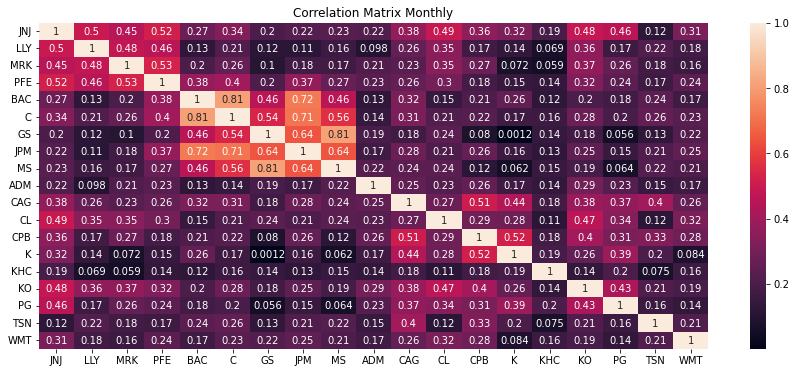

In [534]:
#Create a correlation matrix and color code  using seaborn
corr = wrds_data.iloc[:,8:].corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix Monthly')
plt.show()

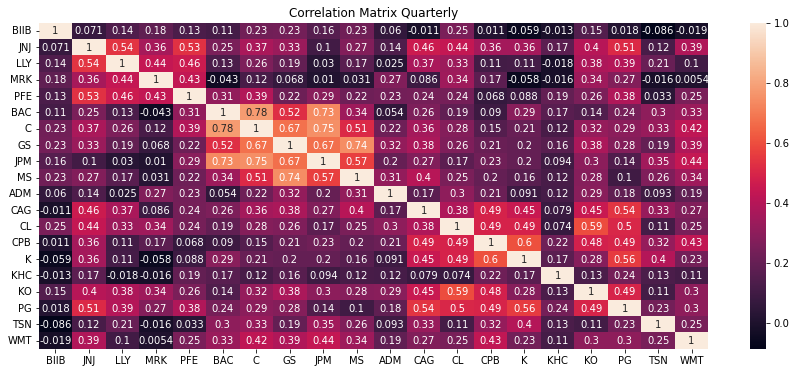

In [535]:
#Create a correlation matrix and color code  using seaborn
corr = wrds_data_q.iloc[:,8:].corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix Quarterly')
plt.show()

> We see that three of the banks BOA, Citi and JPMC are highly correlated with each other based on their 20 year history of monthly returns. Goldman is surprisingly not as correlated with the other banks. This is likely due to the fact that Goldman is more of an investment bank than a commercial bank.
>
> To reinforce this point, we see that Goldman is more correlated with Morgan Stanley than with the other banks.

>The Clustering is based on Quarterly data to make it comparable at a later stage with the other two models (CAPM & FF).

In [536]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

distance_matrix = 1 - corr

# Perform hierarchical/agglomerative clustering
linked = linkage(squareform(distance_matrix), 'complete')

threshold_distance = 1 - 0.36  # Since we're interested in correlation greater than 0.36
clusters = fcluster(linked, threshold_distance, criterion='distance')

# Map the cluster labels back to stock names
stock_names = corr.columns.tolist()
clustered_stocks = {stock: cluster for stock, cluster in zip(stock_names, clusters)}

# Group stocks by their cluster label
grouped_stocks = {}
for stock, cluster_label in clustered_stocks.items():
    grouped_stocks.setdefault(cluster_label, []).append(stock)

# Output the groups
for cluster, stocks in grouped_stocks.items():
    print(f"Cluster {cluster}: {stocks}")

Cluster 2: ['BIIB']
Cluster 1: ['JNJ', 'LLY', 'MRK', 'PFE']
Cluster 4: ['BAC', 'C', 'JPM']
Cluster 3: ['GS', 'MS']
Cluster 8: ['ADM']
Cluster 9: ['CAG', 'CPB', 'K', 'PG']
Cluster 7: ['CL', 'KO']
Cluster 6: ['KHC']
Cluster 10: ['TSN']
Cluster 5: ['WMT']


In [537]:
def convert_to_datetime(quarterly_date):
    year, quarter = quarterly_date.split(' Q')
    year = int(year)
    quarter = int(quarter)
    
    # Calculate the month by mapping quarter to months (e.g., Q1 -> January)
    month = 3 * quarter - 2
    
    # Create a datetime object with the year and month
    return pd.to_datetime(f'{year}-{month:02d}')


In [538]:
# Loading the MEVs
df1 = pd.read_csv('2021-table_1b_historic_international.csv')
df2 = pd.read_csv('2021-table_1a_historic_domestic.csv')

# Drop the Scenario Name column
df1 = df1.drop(columns=['Scenario Name'])
df2 = df2.drop(columns=['Scenario Name'])

df1['Date'] = df1['Date'].apply(convert_to_datetime)
df2['Date'] = df2['Date'].apply(convert_to_datetime)

In [539]:
#Check shape before merging
df1.shape, df2.shape

((180, 13), (180, 17))

In [540]:
# Merge the two dataframes
df_mev = pd.merge(df1, df2, on=['Date'], how='outer')
for column_name in df_mev.columns:
    column_name_new = column_name.replace(' ', '_').replace('-', '_').lower()
    for pattern in ['&', '__', '(', ')']:
        column_name_new = column_name_new.replace(pattern, '')

    correction_dictionary = {'3': 'three', '5': 'five', '10': 'ten'}
    for pattern in ['3', '5', '10']:
        column_name_new = column_name_new.replace(pattern, correction_dictionary[pattern])
    df_mev.rename(columns={column_name: column_name_new}, inplace=True)

In [541]:
#Start from 1999-06
df_mev = df_mev[df_mev['date'] >= '1999-06']
df_mev.reset_index(drop=True, inplace=True)
df_mev.head()

,date,euro_area_real_gdp_growth,euro_area_inflation,euro_area_bilateral_dollar_exchange_rate_usd/euro,developing_asia_real_gdp_growth,developing_asia_inflation,"developing_asia_bilateral_dollar_exchange_rate_f/usd,_index",japan_real_gdp_growth,japan_inflation,japan_bilateral_dollar_exchange_rate_yen/usd,...,three_month_treasury_rate,five_year_treasury_yield,ten_year_treasury_yield,bbb_corporate_yield,mortgage_rate,prime_rate,dow_jones_total_stock_market_index_level,house_price_index_level,commercial_real_estate_price_index_level,market_volatility_index_level
0,1999-07-01,4.800,2.000,1.064,8.300,1.300,102.500,2.100,-0.300,106.800,...,4.700,5.900,6.200,7.800,7.800,8.100,11713.800,97.700,127.000,28.500
1,1999-10-01,4.700,1.800,1.007,10.500,2.300,100.900,0.100,-0.800,102.200,...,5.000,6.100,6.500,8.000,7.800,8.400,13812.700,99.800,130.100,28.800
2,2000-01-01,4.900,2.600,0.957,7.300,1.500,100.000,7.000,-0.500,102.700,...,5.500,6.600,6.700,8.300,8.300,8.700,14296.200,102.300,127.200,27.000
3,2000-04-01,3.600,0.900,0.955,6.900,-0.300,100.700,1.900,-1.100,106.100,...,5.700,6.500,6.400,8.600,8.300,9.200,13618.500,104.900,126.100,33.500
4,2000-07-01,2.200,3.400,0.884,7.800,2.200,101.400,0.100,-0.300,107.900,...,6.000,6.100,6.100,8.200,8.000,9.500,13613.300,107.200,139.300,21.900


In [542]:
#Check shape of wrds_data and df_mev
wrds_data.shape, wrds_data_q.shape, df_mev.shape

((259, 27), (86, 28), (86, 29))

---

### Now that we have the FAMA factors, and the MEVS ready and formatted we can run the three required models

## CAPM MODEL (NOT TWO STEP)

>**Model Development** <br>
>Variable selection for the CAPM model is straightforward. We are going to use the market return as the only independent variable and the stock (various clusters) returns as the dependent variable. <br><br>
**Data Processing** <br>
>We will use the monthly returns data for the period June 1999 to December 2020.
>
>Data is backfilled for completeness where missing
>
>**Note** we used data from WRDS from 2020-2021 for OOS testing<br><br>
**Stressed Period Selection** <br>
>For the stressed period ideally we would have liked to choose 2020-2021 but for this exercise we are assuming that the period beyond 12/2020 is not available to us. Hence, we use the period 2008-2009 as the stressed period.<br><br>
**Granularity** <br>
>For the CAPM model we are going to model at the clustered level, which has been discussed in the preivous section.<br><br>
**Synthetic Time Series** <br>
>For the synthetic time series we are going to use the price weighted returns of the stocks in each cluster.
>
>The prices are back-calculated using the returns and the price data for the period before 2016 as the given dataset does not contain older price data. <br><br>

In [543]:
# Drop Columns 2:8
capm_data = wrds_data.drop(wrds_data.columns[1:7], axis=1)
capm_data

,MKT COMPOSITE RETURN,BIIB,JNJ,LLY,MRK,PFE,BAC,C,GS,JPM,...,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
Date,,,,,,,,,,,,,,,,,,,,,
1999-06-01,0.042,0.524,0.054,-0.001,0.089,0.015,0.136,0.071,0.059,0.191,...,0.025,0.018,-0.018,0.044,-0.053,-0.086,-0.097,-0.048,-0.026,0.129
1999-07-01,-0.034,0.282,-0.075,-0.087,-0.085,-0.071,-0.098,-0.063,-0.114,-0.108,...,-0.101,-0.037,0.002,-0.050,0.051,-0.086,-0.027,0.015,-0.173,-0.128
1999-08-01,-0.022,0.278,0.122,0.136,-0.010,0.113,-0.092,-0.007,-0.072,0.082,...,-0.021,-0.045,0.080,0.000,0.025,-0.086,-0.016,0.092,-0.142,0.045
1999-09-01,-0.032,-0.264,-0.105,-0.144,-0.035,-0.054,-0.076,-0.014,0.016,-0.103,...,-0.071,-0.083,-0.149,-0.118,0.049,-0.086,-0.194,-0.059,0.019,0.071
1999-10-01,0.055,0.232,0.136,0.069,0.224,0.102,0.153,0.232,0.162,0.159,...,0.006,0.151,0.322,0.152,0.059,-0.086,0.219,0.118,-0.076,0.188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,0.047,0.047,0.059,-0.008,0.063,-0.018,0.034,0.022,0.041,0.037,...,0.053,0.030,0.027,0.061,0.036,0.031,0.048,0.055,0.029,0.077
2020-09-01,-0.026,-0.014,-0.030,-0.003,-0.020,-0.029,-0.057,-0.157,-0.019,-0.039,...,0.039,-0.069,-0.027,-0.081,-0.089,-0.145,0.005,0.005,-0.053,0.007
2020-10-01,-0.021,-0.112,-0.079,-0.119,-0.093,-0.033,-0.016,-0.028,-0.060,0.028,...,-0.006,-0.010,0.028,-0.028,-0.026,0.021,-0.027,-0.008,-0.038,-0.008


In [544]:
selected_stocks = capm_data[['BAC', 'C', 'JPM']]
for row in selected_stocks.iterrows():
    selected_stocks.loc[row[0]] = row[1] * wrds_price_monthly.loc[row[0]]
portfolio_return = selected_stocks.sum(axis=1)

In [545]:
portfolio_return

Date
1999-06-01     9.253
1999-07-01    -6.241
1999-08-01     0.691
1999-09-01    -3.020
1999-10-01    21.003
               ...  
2020-08-01     5.685
2020-09-01   -11.911
2020-10-01     1.181
2020-11-01    47.290
2020-12-01    19.777
Length: 259, dtype: float64

In [546]:
#Create a dataframe to store the betas, alphas and r-squared values for each cluster/regression
capm_data_summary = pd.DataFrame(columns=['Cluster','Beta','Alpha','R-Squared'])

X = capm_data['MKT COMPOSITE RETURN']

for cluster,stocks in grouped_stocks.items():
    #Run a OLS regression for each cluster against the market (column 1 of capm_data)
    selected_stocks = capm_data[stocks]
    y = capm_data[stocks].mean(axis=1)
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    #Store the results in the dataframe
    capm_data_summary = capm_data_summary.append({'Cluster':str(stocks),'Beta':results.params[1],'Alpha':results.params[0],'R-Squared':results.rsquared}, ignore_index=True)
capm_data_summary

,Cluster,Beta,Alpha,R-Squared
0,['BIIB'],0.606,0.018,0.040
1,"['JNJ', 'LLY', 'MRK', 'PFE']",0.561,0.003,0.257
2,"['BAC', 'C', 'JPM']",1.609,-0.001,0.522
3,"['GS', 'MS']",1.569,0.002,0.550
4,['ADM'],0.686,0.006,0.144
5,"['CAG', 'CPB', 'K', 'PG']",0.426,0.003,0.178
6,"['CL', 'KO']",0.510,0.003,0.232
7,['KHC'],0.253,-0.067,0.040
8,['TSN'],0.776,0.005,0.133
9,['WMT'],0.396,0.005,0.091


In [547]:
#CAPM Stressed model
capm_data_stressed = capm_data.copy()
#Only keep 2008-2009 data
capm_data_stressed = capm_data_stressed.loc['2008-01-01':'2009-12-01',:]
capm_data_stressed.head()

,MKT COMPOSITE RETURN,BIIB,JNJ,LLY,MRK,PFE,BAC,C,GS,JPM,...,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,-0.063,0.069,-0.056,-0.040,-0.209,0.026,0.068,-0.034,-0.073,0.092,...,-0.055,-0.091,-0.016,-0.119,-0.090,-0.086,-0.041,-0.106,-0.075,0.065
2008-02-01,-0.018,-0.044,-0.013,-0.019,-0.040,-0.034,-0.101,-0.160,-0.151,-0.144,...,0.027,0.028,-0.007,0.022,0.066,-0.086,-0.010,0.010,0.015,-0.024
2008-03-01,-0.018,0.055,0.045,0.030,-0.137,-0.062,-0.032,-0.098,-0.027,0.055,...,-0.089,0.082,0.022,0.050,0.035,-0.086,0.046,0.057,0.105,0.065
2008-04-01,0.057,-0.018,0.032,-0.069,0.001,-0.041,-0.012,0.178,0.157,0.117,...,0.069,-0.010,-0.089,0.030,-0.028,-0.086,-0.035,-0.039,0.114,0.099
2008-05-01,0.011,0.032,-0.000,0.008,0.022,-0.023,-0.096,-0.123,-0.080,-0.099,...,-0.098,-0.001,0.050,-0.040,0.017,-0.086,-0.029,-0.017,0.059,-0.002


In [548]:
capm_data_summary_stressed = pd.DataFrame(columns=['Cluster','Beta','Alpha','R-Squared'])

X = capm_data_stressed['MKT COMPOSITE RETURN']

for cluster,stocks in grouped_stocks.items():
    #Run a OLS regression for each cluster against the market (column 1 of capm_data)
    y = capm_data_stressed[stocks].mean(axis=1)
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    #Store the results in the dataframe
    capm_data_summary_stressed = capm_data_summary_stressed.append({'Cluster':str(stocks),'Beta':results.params[1],'Alpha':results.params[0],'R-Squared':results.rsquared}, ignore_index=True)
    
capm_data_summary_stressed

,Cluster,Beta,Alpha,R-Squared
0,['BIIB'],0.534,0.009,0.117
1,"['JNJ', 'LLY', 'MRK', 'PFE']",0.689,0.002,0.580
2,"['BAC', 'C', 'JPM']",1.991,0.008,0.452
3,"['GS', 'MS']",1.156,0.006,0.455
4,['ADM'],0.340,-0.007,0.056
5,"['CAG', 'CPB', 'K', 'PG']",0.516,0.007,0.425
6,"['CL', 'KO']",0.507,0.008,0.403
7,['KHC'],-0.000,-0.086,-inf
8,['TSN'],1.297,0.013,0.487
9,['WMT'],0.265,0.010,0.128


**Compare Stressed v/s Non-Stressed** <br>
>For the CAPM model we see that the stressed period has a higher beta than the non-stressed period for some clusters. Especially note one of our banking clusters, with Citi, JPMC and BOA [BAC, C, JPM] has a beta of 1.991 in stressed regression vs 1.609 in its non-stressed counterparts.
>
>Similarly the pharmaceutical cluster ['JNJ', 'LLY', 'MRK', 'PFE'] shows a beta of 0.689 vs 0.561 in the stressed and non-stressed periods respectively.
>
>The Kraft Heinz Cluster [KHC] shows an error with R-squared as the data is not available before 2015 and backfilled for not raising errors in our regressions.<br><br>


## FAMA FRENCH MODEL (TWO STEP)

In [549]:
df_mev.set_index('date', inplace=True)

In [550]:
# Drop columns 1:3 and column 7
wrds_data_q.set_index('Date', inplace=True)
ff_data = wrds_data_q.drop(wrds_data.columns[:2], axis=1)
ff_data = ff_data.drop(ff_data.columns[1], axis=1)
ff_data = ff_data.drop(ff_data.columns[3], axis=1)
ff_data.rename(columns={'FAMA-FRENCH SIZE FACTOR (SMB)':'SMB'}, inplace=True)
ff_data.rename(columns={'FAMA-FRENCH VALUE FACTOR (HML)':'HML'}, inplace=True)
ff_data.rename(columns={'FAMA-FRENCH MARKET FACTOR':'MF'}, inplace=True)
ff_data

,MF,SMB,HML,BIIB,JNJ,LLY,MRK,PFE,BAC,C,...,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
Date,,,,,,,,,,,,,,,,,,,,,
1999-07-01,-0.035,0.025,-0.005,0.282,-0.075,-0.087,-0.085,-0.071,-0.098,-0.063,...,-0.101,-0.037,0.002,-0.050,0.051,-0.086,-0.027,0.015,-0.173,-0.128
1999-10-01,0.061,-0.068,-0.032,0.232,0.136,0.069,0.224,0.102,0.153,0.232,...,0.006,0.151,0.322,0.152,0.059,-0.086,0.219,0.118,-0.076,0.188
2000-01-01,-0.047,0.057,-0.018,0.280,-0.081,0.002,0.169,0.112,-0.039,0.019,...,-0.035,-0.050,-0.090,-0.186,-0.217,-0.086,-0.018,-0.079,-0.162,-0.212
2000-04-01,-0.064,-0.069,0.074,-0.353,0.170,0.227,0.114,0.148,-0.070,-0.007,...,-0.041,0.048,0.011,-0.152,-0.063,-0.086,0.002,0.059,-0.066,-0.025
2000-07-01,-0.025,-0.032,0.084,0.042,-0.091,0.035,-0.069,-0.106,0.097,0.166,...,-0.049,0.078,-0.072,-0.087,-0.133,-0.086,0.063,-0.005,0.067,-0.051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,0.021,0.002,-0.019,0.281,0.019,0.017,0.028,0.066,0.070,0.039,...,0.022,-0.113,-0.062,-0.007,-0.014,0.156,-0.002,0.005,-0.040,-0.013
2020-01-01,-0.001,-0.031,-0.063,-0.095,0.019,0.061,-0.062,-0.041,-0.069,-0.064,...,-0.036,-0.034,0.077,-0.015,-0.015,-0.092,0.054,0.002,-0.094,-0.038
2020-04-01,0.137,0.028,-0.014,-0.062,0.144,0.115,0.031,0.175,0.133,0.153,...,0.056,0.147,0.066,0.090,0.092,0.226,0.037,0.079,0.075,0.070


In [551]:
#Regress each FF factor against the market

ff_mev_summary = pd.DataFrame(columns=['Factor','Alpha','R-Squared']+df_mev.columns[1:].tolist())

X = df_mev

for factor in ff_data.columns[:3]:
    y = ff_data[factor]
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    #Store the results in the dataframe
    ff_mev_summary = ff_mev_summary.append({'Factor':factor,'Alpha':results.params[0],'R-Squared':results.rsquared}, ignore_index=True)
    #Save the beta for each factor
    for i in range(0,len(results.params),1):
        if i > 0:
            ff_mev_summary.loc[ff_mev_summary['Factor']==factor,results.params.index[i]] = results.params[i]

In [552]:
ff_mev_summary.T

,0,1,2
Factor,MF,SMB,HML
Alpha,-0.144,-0.178,0.028
R-Squared,0.414,0.295,0.364
euro_area_inflation,0.003,0.012,0.002
euro_area_bilateral_dollar_exchange_rate_usd/euro,-0.020,0.021,0.048
developing_asia_real_gdp_growth,0.002,0.000,0.001
developing_asia_inflation,-0.002,-0.006,0.002
"developing_asia_bilateral_dollar_exchange_rate_f/usd,_index",0.003,0.001,0.001
japan_real_gdp_growth,-0.000,0.002,0.003
japan_inflation,0.000,-0.000,0.006


>For MF (Market Factor), the coefficients for various variables vary. For example, the 3-month Treasury rate and 10-year Treasury yield have positive coefficients, suggesting a positive relationship between these interest rates and the MF factor. On the other hand, the CPI inflation rate has a positive coefficient, indicating a positive relationship with MF.
>
>For SMB (Small Minus Big), the coefficients for the macroeconomic variables also vary. Notably, unemployment rate, 5-year Treasury yield, and the Dow Jones Total Stock Market Index have positive coefficients, suggesting positive relationships with SMB.
>
>For HML (High Minus Low), the coefficients for the macroeconomic variables show mixed relationships. U.K. inflation and BBB corporate yield have positive coefficients, while nominal disposable income growth has a negative coefficient.

In [553]:
#Create a dataframe to store the betas, alphas and r-squared values for each cluster/regression
ff_data_summary = pd.DataFrame(columns=['Cluster','MF','SMB','HML','Alpha','R-Squared'])

X = ff_data.iloc[:,1:4]

for cluster,stocks in grouped_stocks.items():
    #Run a OLS regression for each cluster against the market (column 1 of ff_data)
    y = ff_data[stocks].mean(axis=1)
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    #Store the results in the dataframe
    ff_data_summary = ff_data_summary.append({'Cluster':str(stocks),'MF':results.params[1],'SMB':results.params[2],'HML':results.params[3],'Alpha':results.params[0],'R-Squared':results.rsquared}, ignore_index=True)
    
ff_data_summary

,Cluster,MF,SMB,HML,Alpha,R-Squared
0,['BIIB'],-0.000,0.000,1.000,-0.000,1.000
1,"['JNJ', 'LLY', 'MRK', 'PFE']",-0.476,0.122,0.110,0.003,0.115
2,"['BAC', 'C', 'JPM']",0.638,1.222,0.195,0.015,0.219
3,"['GS', 'MS']",0.418,-0.139,0.137,0.023,0.084
4,['ADM'],0.213,0.190,0.040,0.013,0.015
5,"['CAG', 'CPB', 'K', 'PG']",-0.013,0.246,0.016,0.007,0.031
6,"['CL', 'KO']",-0.393,0.121,0.128,0.001,0.110
7,['KHC'],-0.015,-0.018,-0.007,-0.058,0.000
8,['TSN'],0.699,0.471,-0.067,0.002,0.084
9,['WMT'],-0.248,0.132,0.016,0.007,0.019


>We have regressed FF against the MEVs and the Stock Clusters against FF

> Cluster 0 (['BIIB']):
>
>MF (Market Factor): The coefficient is close to zero (0.000), indicating that this cluster's returns are not significantly influenced by market movements.
>SMB (Small Minus Big): The coefficient is also close to zero (0.000), suggesting that the size factor doesn't have a significant impact on this cluster.
>HML (High Minus Low): The coefficient is 1.000, indicating a strong positive relationship with the high-minus-low factor.
> - Alpha: The alpha is close to zero (-0.000), suggesting that this cluster's returns are in line with the expected returns based on the Fama-French factors.
> - R-Squared: The R-squared value is 1.000, indicating that the Fama-French factors explain all of the variation in this cluster's returns. This suggests a perfect fit.
>
> Cluster 1 (['JNJ', 'LLY', 'MRK', 'PFE']):
>
> MF: The coefficient is -0.476, indicating a negative relationship with the market factor.
> SMB: The coefficient is 0.122, suggesting a slight positive relationship with the size factor.
> HML: The coefficient is 0.110, indicating a positive relationship with the high-minus-low factor.
> - Alpha: The alpha is 0.003, suggesting that this cluster's returns are slightly higher than expected.
> - R-Squared: The R-squared value is 0.115, indicating that the Fama-French factors explain a relatively small portion of the variation in this cluster's returns.
> 
> Cluster 2 (['BAC', 'C', 'JPM']):
>
> MF: The coefficient is 0.638, indicating a positive relationship with the market factor.
> SMB: The coefficient is 1.222, suggesting a strong positive relationship with the size factor.
> HML: The coefficient is 0.195, indicating a positive relationship with the high-minus-low factor.
> - Alpha: The alpha is 0.015, suggesting that this cluster's returns are slightly higher than expected.
> - R-Squared: The R-squared value is 0.219, indicating that the Fama-French factors explain a moderate portion of the variation in this cluster's returns.
> 
> Cluster 3 (['GS', 'MS']):
> 
> MF: The coefficient is 0.418, indicating a positive relationship with the market factor.
> SMB: The coefficient is -0.139, suggesting a negative relationship with the size factor.
> HML: The coefficient is 0.137, indicating a positive relationship with the high-minus-low factor.
> - Alpha: The alpha is 0.023, suggesting that this cluster's returns are slightly higher than expected.
> - R-Squared: The R-squared value is 0.084, indicating that the Fama-French factors explain a relatively small portion of the variation in this cluster's returns.

> Cluster 5 (['CAG', 'CPB', 'K', 'PG']):
> 
> MF: The coefficient is -0.013, indicating a weak negative relationship with the market factor.
> SMB: The coefficient is 0.246, suggesting a strong positive relationship with the size factor.
> HML: The coefficient is 0.016, indicating a positive relationship with the high-minus-low factor.
> - Alpha: The alpha is 0.007, suggesting that this cluster's returns are slightly higher than expected.
> - R-Squared: The R-squared value is 0.031, indicating that the Fama-French factors explain a relatively small portion of the variation in this cluster's returns.
>
> Cluster 6 (['CL', 'KO']):
>
> MF: The coefficient is -0.393, indicating a negative relationship with the market factor.
> SMB: The coefficient is 0.121, suggesting a positive relationship with the size factor.
> HML: The coefficient is 0.128, indicating a positive relationship with the high-minus-low factor.
> - Alpha: The alpha is 0.001, suggesting that this cluster's returns are slightly higher than expected.
> - R-Squared: The R-squared value is 0.110, indicating that the Fama-French factors explain a relatively small portion of the variation in this cluster's returns.

---

### FAMA FRENCH STRESSED

In [554]:
#FF Stressed model
ff_data_stressed = ff_data.copy()
#Only keep 2008-2009 data
ff_data_stressed = ff_data_stressed.loc['2008-01-01':'2009-12-01',:]
ff_data_stressed.head()

,MF,SMB,HML,BIIB,JNJ,LLY,MRK,PFE,BAC,C,...,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,-0.064,-0.009,0.037,0.069,-0.056,-0.040,-0.209,0.026,0.068,-0.034,...,-0.055,-0.091,-0.016,-0.119,-0.090,-0.086,-0.041,-0.106,-0.075,0.065
2008-04-01,0.046,-0.016,-0.010,-0.018,0.032,-0.069,0.001,-0.041,-0.012,0.178,...,0.069,-0.010,-0.089,0.030,-0.028,-0.086,-0.035,-0.039,0.114,0.099
2008-07-01,-0.008,0.025,0.053,0.247,0.063,0.019,-0.129,0.067,0.377,0.133,...,-0.153,0.133,0.079,0.092,0.103,-0.086,-0.011,0.082,-0.004,0.042
2008-10-01,-0.172,-0.025,-0.024,-0.155,-0.115,-0.233,-0.020,-0.040,-0.310,-0.328,...,-0.055,-0.096,-0.163,-0.011,-0.102,-0.086,-0.168,-0.069,-0.269,-0.069
2009-01-01,-0.081,0.003,-0.111,0.021,-0.036,-0.086,-0.061,-0.177,-0.533,-0.469,...,-0.050,0.048,-0.045,0.012,-0.004,-0.086,-0.056,-0.112,0.010,-0.160


In [555]:
#Regress each FF factor against the market

ff_mev_stressed_summary = pd.DataFrame(columns=['Factor','Alpha','R-Squared']+df_mev.columns[1:].tolist())

X = df_mev.loc['2008-01-01':'2009-12-01',:]

for factor in ff_data_stressed.columns[:3]:
    y = ff_data_stressed[factor]
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    #Store the results in the dataframe
    ff_mev_stressed_summary = ff_mev_stressed_summary.append({'Factor':factor,'Alpha':results.params[0],'R-Squared':results.rsquared}, ignore_index=True)
    #Save the beta for each factor
    for i in range(0,len(results.params),1):
        if i > 0:
            ff_mev_stressed_summary.loc[ff_mev_stressed_summary['Factor']==factor,results.params.index[i]] = results.params[i]

In [556]:
ff_mev_stressed_summary.T

,0,1,2
Factor,MF,SMB,HML
Alpha,0.000,0.000,0.000
R-Squared,1.000,1.000,1.000
euro_area_inflation,-0.003,-0.001,-0.002
euro_area_bilateral_dollar_exchange_rate_usd/euro,0.000,0.000,0.000
developing_asia_real_gdp_growth,0.015,0.006,0.011
developing_asia_inflation,-0.004,-0.001,-0.003
"developing_asia_bilateral_dollar_exchange_rate_f/usd,_index",0.006,0.002,0.002
japan_real_gdp_growth,-0.003,0.000,0.001
japan_inflation,0.007,0.002,0.005


The scenario with more stress applied to the factors results in amplified relationships between these factors and the Fama-French factors. Economic and financial factors, interest rates, market and economic indices, exchange rates, GDP and income factors, and inflation and unemployment factors all exhibit stronger relationships, either positive or negative, with the Fama-French factors in this scenario

In [557]:
#Create a dataframe to store the betas, alphas and r-squared values for each cluster/regression
ff_data_Stressed_summary = pd.DataFrame(columns=['Cluster','MF','SMB','HML','Alpha','R-Squared'])

X = ff_data_stressed.iloc[:,1:4]

for cluster,stocks in grouped_stocks.items():
    #Run a OLS regression for each cluster against the market (column 1 of ff_data)
    y = ff_data_stressed[stocks].mean(axis=1)
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    #Store the results in the dataframe
    ff_data_Stressed_summary = ff_data_Stressed_summary.append({'Cluster':str(stocks),'MF':results.params[1],'SMB':results.params[2],'HML':results.params[3],'Alpha':results.params[0],'R-Squared':results.rsquared}, ignore_index=True)
    
ff_data_Stressed_summary

,Cluster,MF,SMB,HML,Alpha,R-Squared
0,['BIIB'],0.000,-0.000,1.000,-0.000,1.000
1,"['JNJ', 'LLY', 'MRK', 'PFE']",-0.172,0.470,0.055,-0.032,0.288
2,"['BAC', 'C', 'JPM']",0.968,3.261,0.064,-0.006,0.844
3,"['GS', 'MS']",2.886,-0.895,0.240,0.017,0.462
4,['ADM'],-1.248,0.250,-0.112,-0.025,0.186
5,"['CAG', 'CPB', 'K', 'PG']",1.238,0.016,0.077,0.001,0.419
6,"['CL', 'KO']",0.317,0.250,0.168,-0.029,0.331
7,['KHC'],0.000,0.000,-0.000,-0.086,-inf
8,['TSN'],2.139,-0.454,0.005,-0.027,0.193
9,['WMT'],-1.984,1.342,0.155,-0.000,0.758


The regression results for different clusters of stocks reveal varying relationships between the Fama-French factors (MF, SMB, HML) and the returns of these clusters. Cluster 0, represented by the stock 'BIIB,' exhibits a strong positive correlation with the HML factor (1.000) but does not show significant dependence on MF or SMB factors. Cluster 7, represented by 'KHC,' displays unusual results with zero coefficients for MF, SMB, and HML, and a highly negative alpha (-0.086), resulting in a negative infinity (inf) R-squared. This suggests that the model may not be suitable for explaining the returns of this cluster, and there could be anomalies or extreme outliers affecting the results. Other clusters, such as Cluster 2 ('BAC,' 'C,' 'JPM') and Cluster 8 ('TSN'), demonstrate strong positive relationships with MF and HML factors, with high R-squared values (0.844 and 0.758, respectively), indicating that these factors play a significant role in explaining the returns of these clusters.

## Multi Factor Model

In [558]:
#Remove the first 7 columns
wrds_data_q = wrds_data_q.iloc[:,7:]
wrds_data_q.head()

,BIIB,JNJ,LLY,MRK,PFE,BAC,C,GS,JPM,MS,ADM,CAG,CL,CPB,K,KHC,KO,PG,TSN,WMT
Date,,,,,,,,,,,,,,,,,,,,
1999-07-01,0.282,-0.075,-0.087,-0.085,-0.071,-0.098,-0.063,-0.114,-0.108,-0.122,-0.101,-0.037,0.002,-0.050,0.051,-0.086,-0.027,0.015,-0.173,-0.128
1999-10-01,0.232,0.136,0.069,0.224,0.102,0.153,0.232,0.162,0.159,0.236,0.006,0.151,0.322,0.152,0.059,-0.086,0.219,0.118,-0.076,0.188
2000-01-01,0.280,-0.081,0.002,0.169,0.112,-0.039,0.019,-0.030,0.040,-0.073,-0.035,-0.050,-0.090,-0.186,-0.217,-0.086,-0.018,-0.079,-0.162,-0.212
2000-04-01,-0.353,0.170,0.227,0.114,0.148,-0.070,-0.007,-0.117,-0.172,-0.076,-0.041,0.048,0.011,-0.152,-0.063,-0.086,0.002,0.059,-0.066,-0.025
2000-07-01,0.042,-0.091,0.035,-0.069,-0.106,0.097,0.166,0.039,0.081,0.094,-0.049,0.078,-0.072,-0.087,-0.133,-0.086,0.063,-0.005,0.067,-0.051


Cluster: 2 Stocks: ['BIIB']


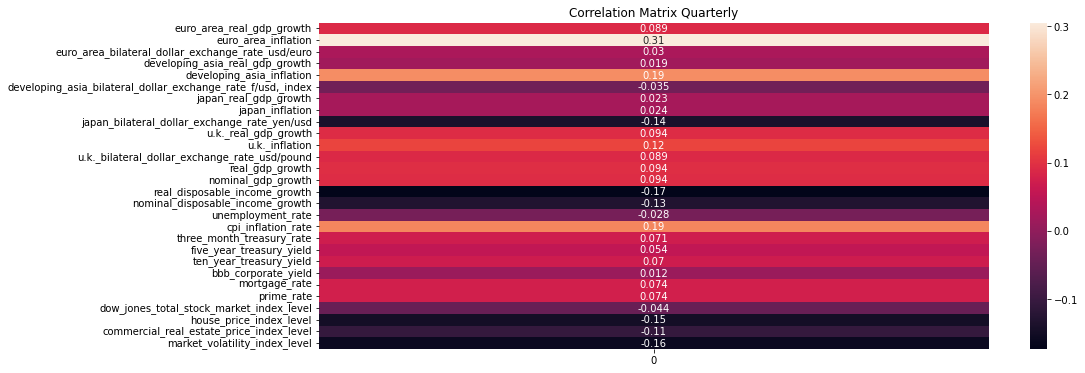

Cluster: 1 Stocks: ['JNJ', 'LLY', 'MRK', 'PFE']


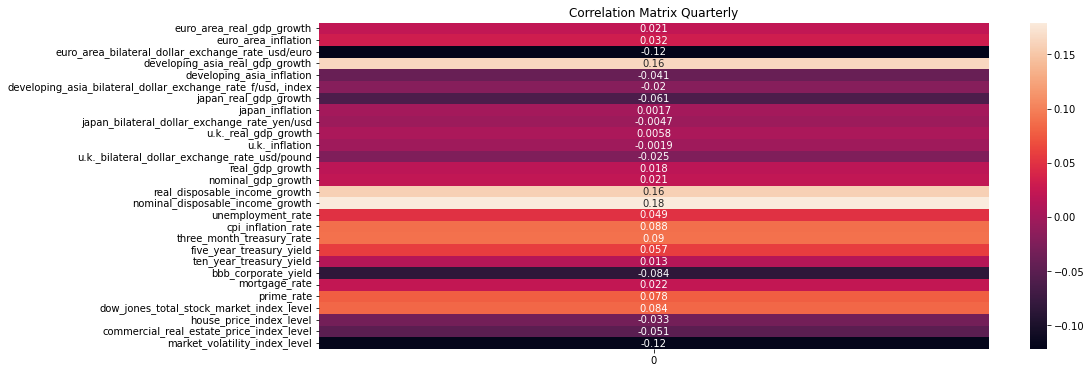

Cluster: 4 Stocks: ['BAC', 'C', 'JPM']


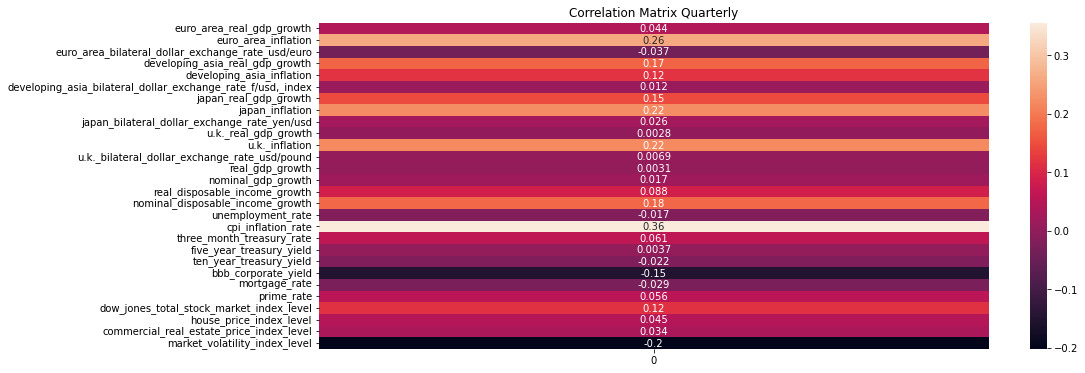

Cluster: 3 Stocks: ['GS', 'MS']


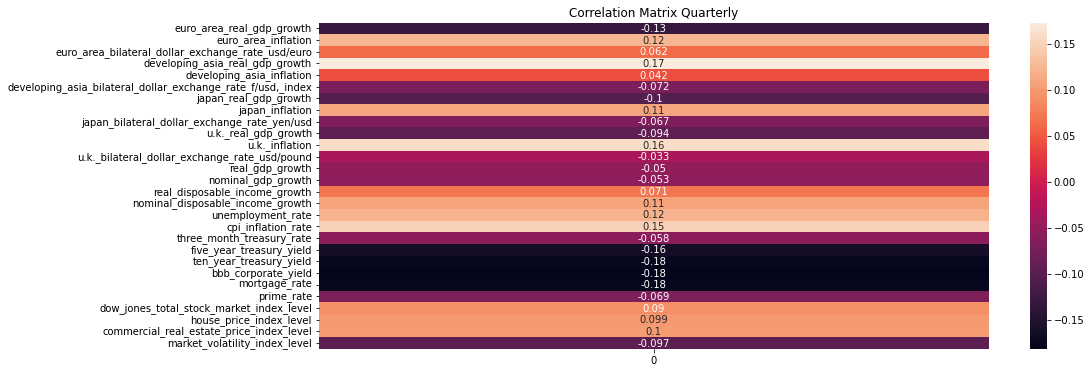

Cluster: 8 Stocks: ['ADM']


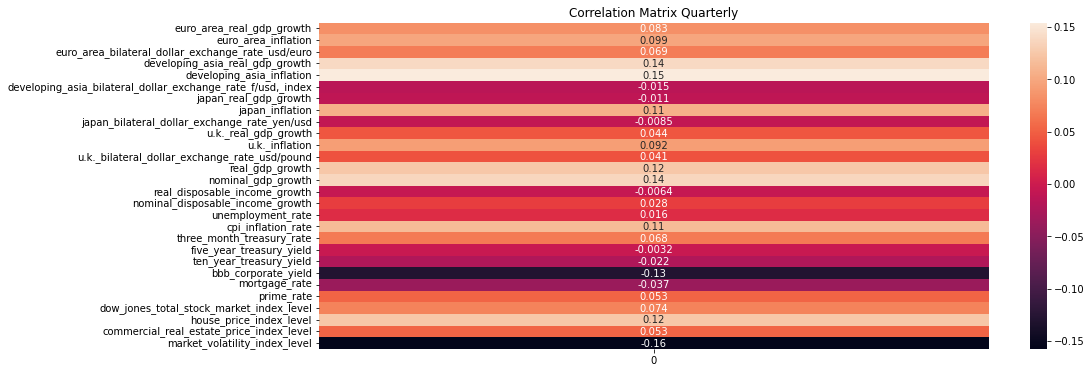

Cluster: 9 Stocks: ['CAG', 'CPB', 'K', 'PG']


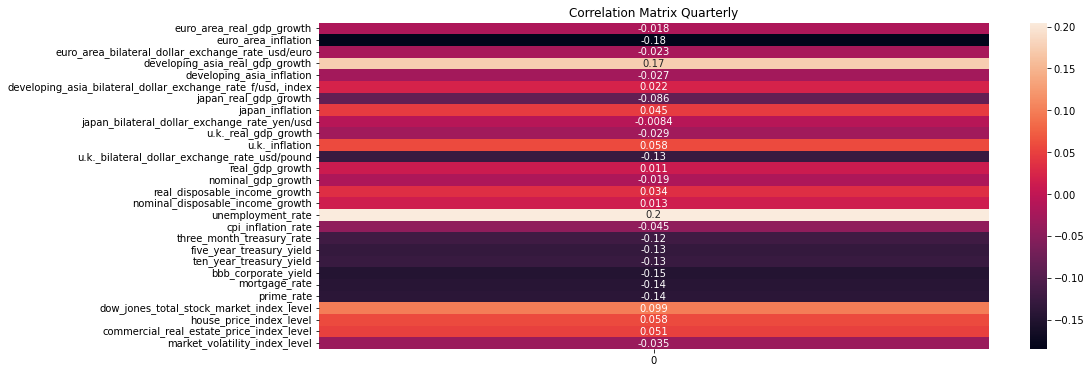

Cluster: 7 Stocks: ['CL', 'KO']


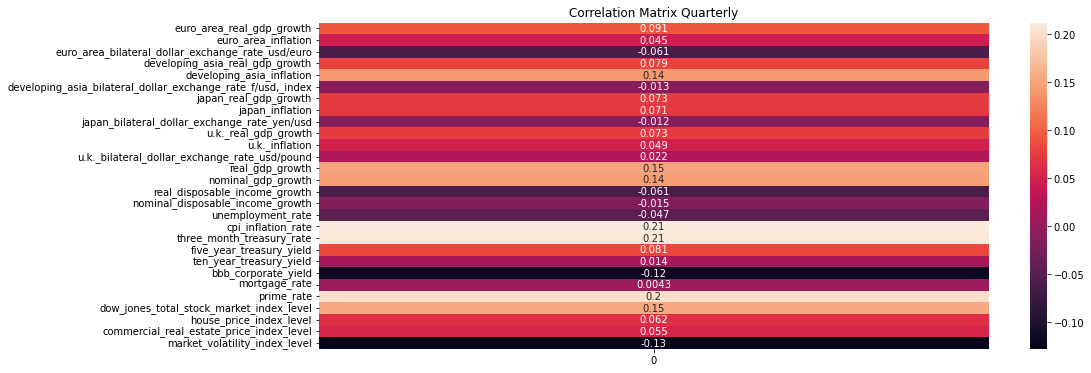

Cluster: 6 Stocks: ['KHC']


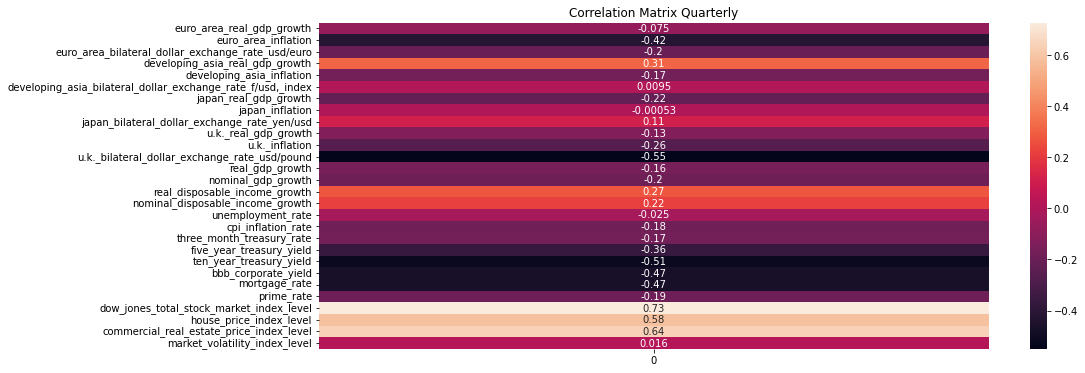

Cluster: 10 Stocks: ['TSN']


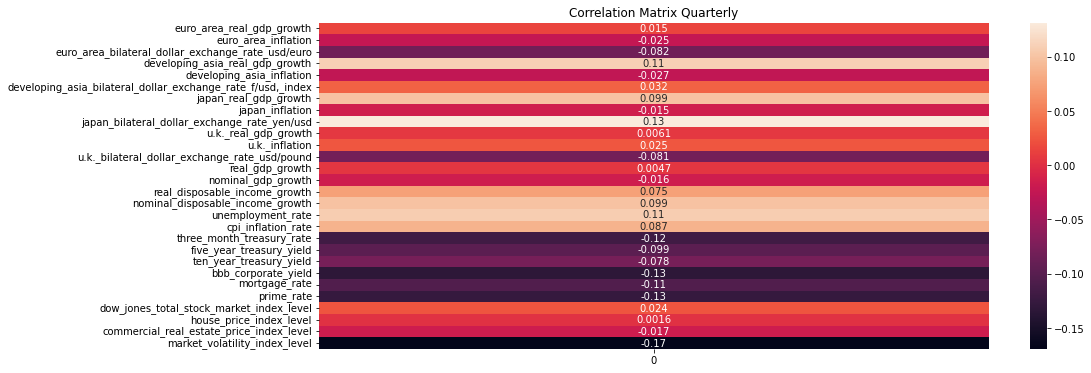

Cluster: 5 Stocks: ['WMT']


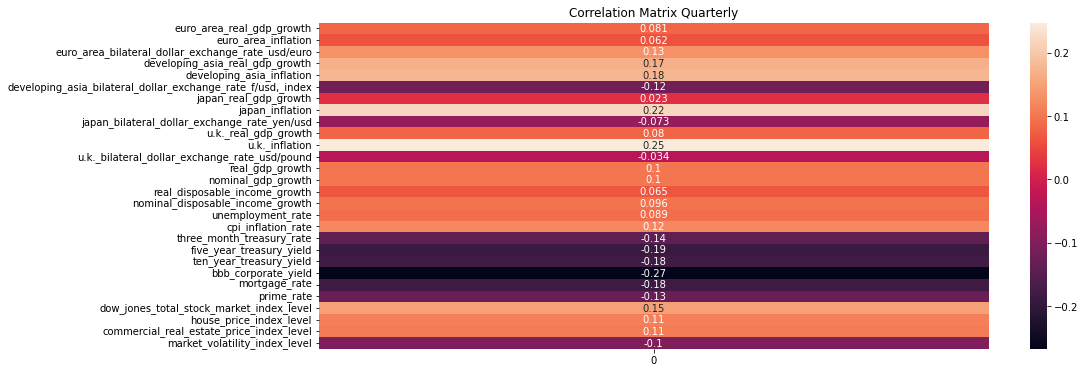

In [559]:
# Run Correlation Matrix for each cluster against the df_mev and show it in a single plot
for cluster,stocks in grouped_stocks.items():
    print("Cluster:", cluster, "Stocks:", stocks)
    corr = df_mev.corrwith(wrds_data_q[stocks].mean(axis=1))
    plt.figure(figsize=(15,6))
    sns.heatmap(corr.to_frame(), annot=True)
    plt.title('Correlation Matrix Quarterly')
    plt.show()

>**Variable Selection** <br>
>We see that banks are negatively correlated with the bond yields and positively correlated to the inflation metrics.
>
>While correlation analysis does give an idea and give credence to the economic ideology behind the clusters, we are going to use some more statistically robust methods to decide the factors that we are going to use in our model.
>

In [560]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
# Standardize features
scaler = StandardScaler()
X = df_mev
X_std = scaler.fit_transform(df_mev)
for cluster,stocks in grouped_stocks.items():
    y = wrds_data_q[stocks].mean(axis=1)
    # Initialize Lasso model and fit to data
    lasso = LassoCV(cv=5)
    lasso.fit(X_std, y)

    # Get coefficients of selected features
    coef = pd.Series(lasso.coef_, index=X.columns)
    important_features = coef[coef != 0].index.tolist()

    # Print the most important features and the optimal alpha value
    print('The most important features for cluster', cluster, 'with stocks', stocks, 'are:')
    print(important_features)
    print(f'The optimal alpha value is: {lasso.alpha_}')
    print('------------------')

    #generate a feature_importance dataframe
    feature_importance = pd.DataFrame({'feature':X.columns, 'importance':lasso.coef_})

The most important features for cluster 2 with stocks ['BIIB'] are:
['euro_area_inflation', 'real_disposable_income_growth']
The optimal alpha value is: 0.01791917935814448
------------------
The most important features for cluster 1 with stocks ['JNJ', 'LLY', 'MRK', 'PFE'] are:
['nominal_disposable_income_growth']
The optimal alpha value is: 0.009339376302453023
------------------
The most important features for cluster 4 with stocks ['BAC', 'C', 'JPM'] are:
[]
The optimal alpha value is: 0.034246786657296406
------------------
The most important features for cluster 3 with stocks ['GS', 'MS'] are:
['bbb_corporate_yield']
The optimal alpha value is: 0.016075048642200725
------------------
The most important features for cluster 8 with stocks ['ADM'] are:
['market_volatility_index_level']
The optimal alpha value is: 0.012774915565767354
------------------
The most important features for cluster 9 with stocks ['CAG', 'CPB', 'K', 'PG'] are:
[]
The optimal alpha value is: 0.00883173529563

>We see that the Lasso regression model selection does not give use factors for quite a few of our clusters. This is likely due to the fact that the number of observations is not enough to make a robust model.
>
>Nevertheless, lets see if a forward stepwise regression can give us some more factors to work with.
>

In [561]:
#Run forward stepwise regression and print the factors to be included in the model for each cluster
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

#Dataframe to save factors to use for each cluster
feature_selection = pd.DataFrame(columns=['Cluster','Factors'])

for cluster,stocks in grouped_stocks.items():
    y = wrds_data_q[stocks].mean(axis=1)
    # Initialize Linear Regression model
    lr = LinearRegression()

    # Initialize Forward Stepwise Selection
    sfs = SequentialFeatureSelector(lr, n_features_to_select=5, direction='forward')

    # Fit SFS
    sfs.fit(X, y)

    # Get selected feature indices
    feature_idx = sfs.get_support()

    # Get selected feature names
    feature_name = X.columns[feature_idx]

    # Print the selected features
    print('The most important features for cluster', cluster, 'with stocks', stocks, 'are:')
    print(feature_name)
    print('------------------')
    
    #Save the factors to use for each cluster
    feature_selection = feature_selection.append({'Cluster':cluster,'Factors':feature_name}, ignore_index=True)

The most important features for cluster 2 with stocks ['BIIB'] are:
Index(['euro_area_bilateral_dollar_exchange_rate_usd/euro',
       'developing_asia_inflation',
       'japan_bilateral_dollar_exchange_rate_yen/usd',
       'ten_year_treasury_yield', 'house_price_index_level'],
      dtype='object')
------------------
The most important features for cluster 1 with stocks ['JNJ', 'LLY', 'MRK', 'PFE'] are:
Index(['euro_area_bilateral_dollar_exchange_rate_usd/euro',
       'developing_asia_real_gdp_growth',
       'developing_asia_bilateral_dollar_exchange_rate_f/usd,_index',
       'u.k._bilateral_dollar_exchange_rate_usd/pound',
       'ten_year_treasury_yield'],
      dtype='object')
------------------
The most important features for cluster 4 with stocks ['BAC', 'C', 'JPM'] are:
Index(['japan_bilateral_dollar_exchange_rate_yen/usd',
       'real_disposable_income_growth', 'unemployment_rate', 'mortgage_rate',
       'dow_jones_total_stock_market_index_level'],
      dtype='object')


>The forward stepwise selector will give us as many estimators as we would like. We selected 5 as a reasonable number of factors to use in our model.
>
>Still unsatisfied, we ran the Boruta selector to see if we can get some more relevant factors to work with.
>

In [562]:
#Use Boruta to select the factors to use for each cluster
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

#Dataframe to save factors to use for each cluster
feature_selection_boruta = pd.DataFrame(columns=['Cluster','Factors'])

for cluster,stocks in grouped_stocks.items():
    y = wrds_data_q[stocks].mean(axis=1)
    # Initialize Random Forest Regressor
    rf = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=1)

    # Initialize Boruta
    boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)

    # Fit Boruta
    boruta.fit(X.values, y.values)

    # Get selected feature indices
    feature_idx = boruta.support_

    # Get selected feature names
    feature_name = X.columns[feature_idx]

    # Print the selected features
    print('The most important features for cluster', cluster, 'with stocks', stocks, 'are:')
    print(feature_name)
    print('------------------')
    
    #Save the factors to use for each cluster
    feature_selection_boruta = feature_selection_boruta.append({'Cluster':cluster,'Factors':feature_name}, ignore_index=True)

The most important features for cluster 2 with stocks ['BIIB'] are:
Index(['house_price_index_level', 'commercial_real_estate_price_index_level'], dtype='object')
------------------
The most important features for cluster 1 with stocks ['JNJ', 'LLY', 'MRK', 'PFE'] are:
Index(['ten_year_treasury_yield', 'bbb_corporate_yield'], dtype='object')
------------------
The most important features for cluster 4 with stocks ['BAC', 'C', 'JPM'] are:
Index(['euro_area_inflation', 'bbb_corporate_yield',
       'dow_jones_total_stock_market_index_level'],
      dtype='object')
------------------
The most important features for cluster 3 with stocks ['GS', 'MS'] are:
Index(['bbb_corporate_yield'], dtype='object')
------------------
The most important features for cluster 8 with stocks ['ADM'] are:
Index([], dtype='object')
------------------
The most important features for cluster 9 with stocks ['CAG', 'CPB', 'K', 'PG'] are:
Index(['developing_asia_real_gdp_growth', 'bbb_corporate_yield'], dtype='obje

---

>As noted above the variable selection is not really able to ascertain the factors that we should use in our model. We will use all the factors that we have and see how the model performs.
>
>Furthermore, the regression should be able to give us an idea of the factors that are not significant and we can drop them from the model.

In [576]:
#Run a regression with all the factors and save the results in a dataframe
multi_model_summary = pd.DataFrame(columns=['Cluster','Alpha','R-Squared']+df_mev.columns[1:].tolist())

X = df_mev

for cluster,stocks in grouped_stocks.items():
    #Run a OLS regression for each cluster against the market (column 1 of ff_data)
    y = wrds_data_q[stocks].mean(axis=1)
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    #Store the results in the dataframe
    multi_model_summary = multi_model_summary.append({'Cluster':str(stocks),'Alpha':results.params[0],'R-Squared':results.rsquared}, ignore_index=True)
    #Save the beta for each factor
    for i in range(0,len(results.params),1):
        if i > 0:
            multi_model_summary.loc[multi_model_summary['Cluster']==str(stocks),results.params.index[i]] = results.params[i]
            

In [577]:
multi_model_summary

,Cluster,Alpha,R-Squared,euro_area_inflation,euro_area_bilateral_dollar_exchange_rate_usd/euro,developing_asia_real_gdp_growth,developing_asia_inflation,"developing_asia_bilateral_dollar_exchange_rate_f/usd,_index",japan_real_gdp_growth,japan_inflation,...,five_year_treasury_yield,ten_year_treasury_yield,bbb_corporate_yield,mortgage_rate,prime_rate,dow_jones_total_stock_market_index_level,house_price_index_level,commercial_real_estate_price_index_level,market_volatility_index_level,euro_area_real_gdp_growth
0,['BIIB'],0.769,0.356,0.058,-0.114,0.001,-0.012,0.000,-0.007,0.001,...,-0.184,0.098,-0.065,0.126,-0.210,0.000,-0.003,0.002,-0.000,0.011
1,"['JNJ', 'LLY', 'MRK', 'PFE']",0.402,0.246,-0.007,-0.116,0.000,0.003,-0.004,-0.002,-0.003,...,0.037,-0.062,-0.009,0.042,-0.036,0.000,0.000,-0.001,0.000,-0.003
2,"['BAC', 'C', 'JPM']",-0.339,0.372,0.013,-0.099,0.004,-0.009,0.006,0.006,0.015,...,-0.043,0.051,0.001,-0.067,-0.047,0.000,-0.002,0.001,0.000,0.000
3,"['GS', 'MS']",0.046,0.412,0.008,0.020,0.007,-0.005,0.005,0.001,0.011,...,-0.065,0.045,-0.009,-0.065,-0.113,-0.000,-0.003,0.002,0.000,-0.017
4,['ADM'],0.102,0.290,0.021,0.380,0.001,0.002,0.000,-0.007,0.001,...,-0.132,0.053,-0.024,0.019,-0.093,-0.000,-0.000,-0.001,0.001,0.017
5,"['CAG', 'CPB', 'K', 'PG']",-0.167,0.408,-0.015,-0.101,0.001,0.000,0.004,-0.001,0.004,...,-0.011,0.047,-0.020,-0.029,-0.059,-0.000,-0.002,0.002,-0.000,-0.001
6,"['CL', 'KO']",0.033,0.379,-0.011,-0.280,-0.000,-0.002,0.001,-0.002,0.001,...,-0.042,0.080,-0.019,-0.047,-0.024,0.000,-0.001,0.001,0.000,-0.002
7,['KHC'],-0.015,0.831,-0.013,-0.204,0.004,0.003,0.001,-0.002,-0.002,...,-0.074,0.033,-0.003,0.046,-0.012,0.000,0.001,0.000,-0.000,0.003
8,['TSN'],-0.390,0.295,-0.020,-0.260,-0.003,-0.008,0.001,0.003,-0.011,...,-0.160,0.169,-0.023,0.002,0.011,-0.000,-0.001,0.002,-0.003,-0.002
9,['WMT'],-0.159,0.404,-0.014,0.380,0.008,0.005,0.002,-0.001,0.002,...,-0.001,-0.011,-0.038,0.008,0.054,-0.000,-0.001,-0.001,0.002,-0.009


### Stressed Multi Factor Model

In [578]:
#Run a regression with all the factors and save the results in a dataframe
multi_model_stressed_summary = pd.DataFrame(columns=['Cluster','Alpha','R-Squared']+df_mev.columns[1:].tolist())

X = df_mev.loc['2008-01-01':'2009-12-01',:]

for cluster,stocks in grouped_stocks.items():
    #Run a OLS regression for each cluster against the market (column 1 of ff_data)
    y = wrds_data_q.loc['2008-01-01':'2009-12-01',stocks].mean(axis=1)
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    #Store the results in the dataframe
    multi_model_stressed_summary = multi_model_stressed_summary.append({'Cluster':str(stocks),'Alpha':results.params[0],'R-Squared':results.rsquared}, ignore_index=True)
    #Save the beta for each factor
    for i in range(0,len(results.params),1):
        if i > 0:
            multi_model_stressed_summary.loc[multi_model_stressed_summary['Cluster']==str(stocks),results.params.index[i]] = results.params[i]
            

In [579]:
multi_model_stressed_summary

,Cluster,Alpha,R-Squared,euro_area_inflation,euro_area_bilateral_dollar_exchange_rate_usd/euro,developing_asia_real_gdp_growth,developing_asia_inflation,"developing_asia_bilateral_dollar_exchange_rate_f/usd,_index",japan_real_gdp_growth,japan_inflation,...,five_year_treasury_yield,ten_year_treasury_yield,bbb_corporate_yield,mortgage_rate,prime_rate,dow_jones_total_stock_market_index_level,house_price_index_level,commercial_real_estate_price_index_level,market_volatility_index_level,euro_area_real_gdp_growth
0,['BIIB'],0.000,1.000,-0.001,0.000,0.013,-0.003,0.003,-0.004,0.007,...,0.002,0.002,0.002,0.003,-0.000,0.000,-0.005,0.004,-0.006,0.007
1,"['JNJ', 'LLY', 'MRK', 'PFE']",0.000,1.000,-0.001,0.000,0.006,-0.003,0.003,-0.003,0.003,...,0.001,0.001,0.002,0.002,-0.001,0.000,-0.003,-0.001,-0.001,0.003
2,"['BAC', 'C', 'JPM']",0.000,1.000,-0.005,0.001,0.035,-0.010,0.008,0.006,0.019,...,0.007,0.005,0.008,0.007,-0.002,0.000,-0.016,0.005,-0.002,0.021
3,"['GS', 'MS']",0.000,1.000,-0.001,0.000,0.008,-0.003,0.005,-0.003,0.004,...,0.002,0.001,0.002,0.002,-0.001,-0.000,-0.003,0.002,-0.008,0.002
4,['ADM'],0.000,1.000,-0.004,0.000,0.010,-0.004,0.006,-0.016,0.002,...,0.002,0.002,0.004,0.002,-0.001,0.000,0.000,-0.003,-0.003,0.001
5,"['CAG', 'CPB', 'K', 'PG']",0.000,1.000,-0.001,0.000,0.007,-0.003,0.004,-0.001,0.005,...,0.002,0.001,0.002,0.002,-0.001,0.000,-0.006,0.000,-0.000,0.004
6,"['CL', 'KO']",-0.000,1.000,0.001,-0.000,0.000,0.000,0.000,0.003,0.000,...,-0.000,-0.000,-0.001,-0.000,0.000,-0.000,-0.000,0.000,-0.002,0.001
7,['KHC'],-0.000,-inf,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,...,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000
8,['TSN'],-0.000,1.000,0.001,-0.000,-0.002,0.000,-0.000,0.006,0.001,...,-0.000,-0.000,-0.001,-0.001,-0.000,-0.000,-0.002,0.002,-0.005,-0.001
9,['WMT'],0.000,1.000,-0.001,0.000,0.006,-0.002,0.001,-0.002,0.004,...,0.001,0.001,0.002,0.001,-0.000,0.000,-0.004,0.000,-0.000,0.003


>The stressed period being just 12 points, makes the regression with all the variables moot, as is apparent from the 0 alphas, 100% R squared values

## 2. Model risk assessment and controls
    1. i. Outcome analysis to substantiate the reasonableness of the projection outcomes
       1. • Back-test your portfolio value projections and discuss the reliability of each modeling approach based on the projections.
       2. • Discuss the benchmarking results by comparing the reasonableness of each model’s projections. Which model performs the best? Why?
    2. ii. Discuss the potential model risks as the sources of uncertainties in the forecasting process
       1. • Model complexity and interpretability
       2. • Discuss how model search might cause uncertainties in the forecasts
       3. • Which model is more prone to the Law of Small Numbers? Why?

In [626]:
# Project Fama-French factors for 2020-2021 using the 2020-2021 MEVs
scenario1 = pd.read_csv('2021-table_2a_supervisory_baseline_domestic.csv')
scenario1 = scenario1.drop(columns=['Scenario Name'])
scenario1["Date"] = scenario1['Date'].apply(convert_to_datetime)
for column_name in scenario1.columns:
    column_name_new = column_name.replace(' ', '_').replace('-', '_').lower()
    for pattern in ['&', '__', '(', ')']:
        column_name_new = column_name_new.replace(pattern, '')

    correction_dictionary = {'3': 'three', '5': 'five', '10': 'ten'}
    for pattern in ['3', '5', '10']:
        column_name_new = column_name_new.replace(pattern, correction_dictionary[pattern])
    scenario1.rename(columns={column_name: column_name_new}, inplace=True)

In [627]:
# Project Fama-French factors for 2020-2021 using the 2020-2021 MEVs
scenario2 = pd.read_csv('2021-table_2b_supervisory_baseline_international.csv')
scenario2 = scenario2.drop(columns=['Scenario Name'])
scenario2["Date"] = scenario2['Date'].apply(convert_to_datetime)
for column_name in scenario2.columns:
    column_name_new = column_name.replace(' ', '_').replace('-', '_').lower()
    for pattern in ['&', '__', '(', ')']:
        column_name_new = column_name_new.replace(pattern, '')

    correction_dictionary = {'3': 'three', '5': 'five', '10': 'ten'}
    for pattern in ['3', '5', '10']:
        column_name_new = column_name_new.replace(pattern, correction_dictionary[pattern])
    scenario2.rename(columns={column_name: column_name_new}, inplace=True)

In [628]:
scenario = pd.merge(scenario2, scenario1, on=['date'], how='outer')

In [629]:
scenario.set_index('date', inplace=True)
scenario

,euro_area_real_gdp_growth,euro_area_inflation,euro_area_bilateral_dollar_exchange_rate_usd/euro,developing_asia_real_gdp_growth,developing_asia_inflation,"developing_asia_bilateral_dollar_exchange_rate_f/usd,_index",japan_real_gdp_growth,japan_inflation,japan_bilateral_dollar_exchange_rate_yen/usd,u.k._real_gdp_growth,...,three_month_treasury_rate,five_year_treasury_yield,ten_year_treasury_yield,bbb_corporate_yield,mortgage_rate,prime_rate,dow_jones_total_stock_market_index_level,house_price_index_level,commercial_real_estate_price_index_level,market_volatility_index_level
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,13.200,1.700,1.224,0.600,2.600,92.100,4.800,0.800,103.000,21.500,...,0.100,0.400,1.000,2.400,2.700,3.200,39528.300,226.900,294.100,32.800
2021-04-01,1.300,1.500,1.225,1.600,2.000,91.900,0.700,1.200,102.700,1.700,...,0.100,0.500,1.100,2.600,2.700,3.200,39847.100,228.900,289.600,29.200
2021-07-01,2.500,1.300,1.226,3.200,2.300,91.700,1.500,0.800,102.500,3.500,...,0.100,0.600,1.200,2.700,2.800,3.200,40176.700,230.900,285.100,27.300
2021-10-01,3.800,1.100,1.227,4.800,2.600,91.500,2.200,0.400,102.200,5.200,...,0.100,0.600,1.300,2.800,2.800,3.200,40515.000,233.000,288.100,26.500
2022-01-01,5.000,1.000,1.234,6.400,2.900,91.600,2.900,0.000,102.600,6.900,...,0.100,0.700,1.400,2.900,2.900,3.200,40860.700,235.200,290.700,26.300
2022-04-01,4.300,1.100,1.241,6.100,2.700,91.600,2.500,0.200,103.000,5.200,...,0.200,0.800,1.500,3.000,3.000,3.200,41213.500,237.400,293.500,26.300
2022-07-01,3.500,1.200,1.248,5.800,2.500,91.700,2.100,0.400,103.300,3.500,...,0.200,0.900,1.500,3.100,3.100,3.200,41572.600,239.600,296.200,26.200
2022-10-01,2.800,1.300,1.256,5.500,2.400,91.700,1.700,0.600,103.700,1.900,...,0.200,1.000,1.600,3.200,3.100,3.200,41937.600,241.900,299.000,26.200
2023-01-01,2.100,1.400,1.256,5.200,2.200,91.700,1.300,0.800,103.700,0.400,...,0.500,1.100,1.600,3.300,3.100,3.500,42308.000,244.200,301.900,26.400


In [643]:
#Fit the Fama french factors to the df_mev and predict the factors for 2020-2021
X = df_mev
ff_data_forecast = pd.DataFrame(columns=['MF','SMB','HML'], index=scenario.index)
#Use linear regression to fit the factors
lr = LinearRegression()

for factor in ff_data.columns[:3]:
    y = ff_data[factor]
    X = sm.add_constant(X)
    lr.fit(X, y)
    ff_data_forecast[factor] = lr.predict(sm.add_constant(scenario))


In [644]:
ff_data_forecast

,MF,SMB,HML
date,,,
2021-01-01,0.112,-0.065,-0.007
2021-04-01,-0.010,0.027,-0.013
2021-07-01,-0.023,0.017,-0.014
2021-10-01,-0.003,0.004,-0.014
2022-01-01,0.012,-0.018,-0.003
2022-04-01,0.004,-0.009,-0.001
2022-07-01,-0.013,-0.007,0.008
2022-10-01,-0.021,0.001,0.003
2023-01-01,-0.021,0.001,0.010


#### FF factors have been predicted, now using these to predict the stock returns

In [662]:
#Make a dataframe with all the clusters as columns and ff_data_forecast.index as index
stock_data_forecast = pd.DataFrame(index=ff_data_forecast.index)
for cluster,stocks in grouped_stocks.items():
    stock_data_forecast[cluster] = wrds_data_q[stocks].mean(axis=1)

In [663]:
X = ff_data.iloc[:,0:3]
for cluster,stocks in grouped_stocks.items():
    #Run a OLS regression for each cluster against the market (column 1 of ff_data)
    y = ff_data[stocks].mean(axis=1)
    X = sm.add_constant(X)
    lr.fit(X, y)
    stock_data_forecast[cluster] = lr.predict(sm.add_constant(ff_data_forecast))

In [664]:
stock_data_forecast

,2,1,4,3,8,9,7,6,10,5
date,,,,,,,,,,
2021-01-01,0.051,0.107,0.149,0.181,0.090,0.071,0.107,-0.007,0.047,0.117
2021-04-01,0.051,-0.024,-0.019,-0.004,-0.005,-0.013,-0.024,-0.072,-0.014,-0.026
2021-07-01,0.040,-0.025,-0.040,-0.020,-0.013,-0.017,-0.026,-0.074,-0.026,-0.030
2021-10-01,0.042,-0.005,-0.014,0.009,0.002,-0.004,-0.006,-0.064,-0.017,-0.008
2022-01-01,0.024,0.019,0.018,0.032,0.017,0.011,0.017,-0.054,-0.006,0.018
2022-04-01,0.024,0.008,0.009,0.019,0.010,0.005,0.006,-0.059,-0.008,0.007
2022-07-01,0.006,-0.003,-0.005,-0.007,-0.000,-0.001,-0.006,-0.066,-0.014,-0.005
2022-10-01,0.012,-0.012,-0.020,-0.018,-0.007,-0.008,-0.015,-0.070,-0.020,-0.016
2023-01-01,0.005,-0.012,-0.013,-0.020,-0.006,-0.006,-0.015,-0.070,-0.016,-0.015


### We are plotting a sample forecast for BIIB below. Other plots maybe constructed in a similar manner.

<AxesSubplot:xlabel='date'>

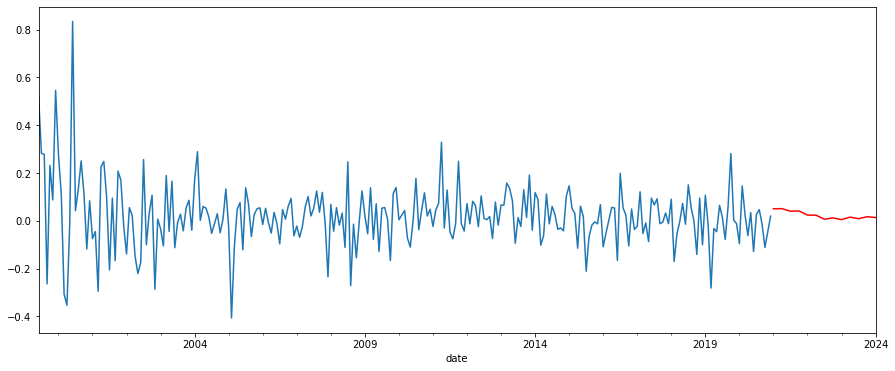

In [666]:
#set figure size
plt.figure(figsize=(15,6))
wrds_data["BIIB"].plot()
stock_data_forecast[2].plot(color='red')

## MULTI FACTOR MODEL PREDICTION

In [669]:
X = df_mev
lr = LinearRegression()
stock_data_forecast_MMF = pd.DataFrame(index=ff_data_forecast.index)
for cluster,stocks in grouped_stocks.items():
    stock_data_forecast_MMF[cluster] = wrds_data_q[stocks].mean(axis=1)
for cluster,stocks in grouped_stocks.items():
    #Run a OLS regression for each cluster against the market (column 1 of ff_data)
    y = wrds_data_q[stocks].mean(axis=1)
    X = sm.add_constant(X)
    lr.fit(X, y)
    stock_data_forecast_MMF[cluster] = lr.predict(sm.add_constant(scenario))  

In [670]:
stock_data_forecast_MMF

,2,1,4,3,8,9,7,6,10,5
date,,,,,,,,,,
2021-01-01,-0.067,0.219,0.311,0.123,0.062,-0.019,0.100,0.020,0.167,0.155
2021-04-01,0.242,-0.071,-0.035,-0.152,-0.033,-0.032,0.011,0.029,-0.152,-0.194
2021-07-01,0.190,-0.076,-0.068,-0.205,-0.070,-0.062,-0.020,0.053,-0.171,-0.183
2021-10-01,0.146,-0.037,-0.009,-0.160,-0.053,-0.060,0.000,0.074,-0.111,-0.122
2022-01-01,0.060,0.030,0.067,-0.102,-0.032,-0.060,0.016,0.077,-0.055,-0.036
2022-04-01,0.122,0.007,0.049,-0.127,-0.035,-0.059,0.008,0.083,-0.085,-0.081
2022-07-01,0.130,-0.006,0.027,-0.164,-0.060,-0.069,-0.012,0.084,-0.126,-0.110
2022-10-01,0.155,-0.035,0.008,-0.197,-0.075,-0.073,-0.017,0.082,-0.152,-0.150
2023-01-01,0.147,-0.040,0.011,-0.193,-0.068,-0.072,-0.016,0.076,-0.166,-0.165


### We are plotting a sample forecast for BIIB below. Other plots maybe constructed in a similar manner.

<AxesSubplot:xlabel='date'>

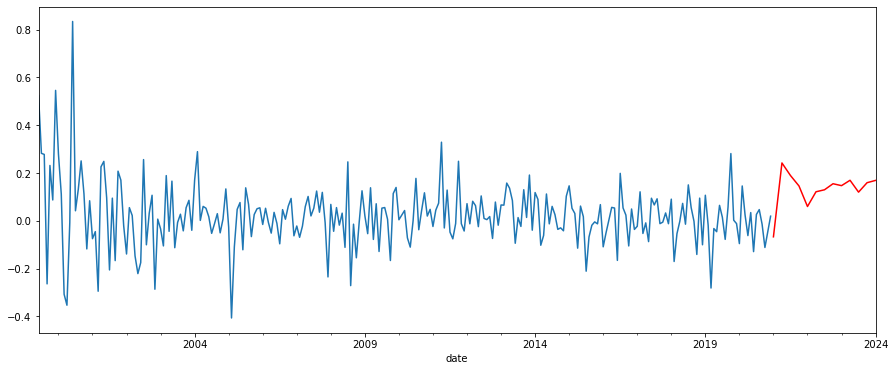

In [671]:
#set figure size
plt.figure(figsize=(15,6))
wrds_data["BIIB"].plot()
stock_data_forecast_MMF[2].plot(color='red')

## 3. Repeat necessary steps in 1 and 2 for the supervisory baseline domestic scenario.

Compare the forecasting results from the two scenarios.

In [682]:
# Project Fama-French factors for 2020-2021 using the 2020-2021 MEVs
scenario1 = pd.read_csv('2021-table_3a_supervisory_severely_adverse_domestic.csv')
scenario1 = scenario1.drop(columns=['Scenario Name'])
scenario1["Date"] = scenario1['Date'].apply(convert_to_datetime)
for column_name in scenario1.columns:
    column_name_new = column_name.replace(' ', '_').replace('-', '_').lower()
    for pattern in ['&', '__', '(', ')']:
        column_name_new = column_name_new.replace(pattern, '')

    correction_dictionary = {'3': 'three', '5': 'five', '10': 'ten'}
    for pattern in ['3', '5', '10']:
        column_name_new = column_name_new.replace(pattern, correction_dictionary[pattern])
    scenario1.rename(columns={column_name: column_name_new}, inplace=True)

In [683]:
# Project Fama-French factors for 2020-2021 using the 2020-2021 MEVs
scenario2 = pd.read_csv('2021-table_3b_supervisory_severely_adverse_international.csv')
scenario2 = scenario2.drop(columns=['Scenario Name'])
scenario2["Date"] = scenario2['Date'].apply(convert_to_datetime)
for column_name in scenario2.columns:
    column_name_new = column_name.replace(' ', '_').replace('-', '_').lower()
    for pattern in ['&', '__', '(', ')']:
        column_name_new = column_name_new.replace(pattern, '')

    correction_dictionary = {'3': 'three', '5': 'five', '10': 'ten'}
    for pattern in ['3', '5', '10']:
        column_name_new = column_name_new.replace(pattern, correction_dictionary[pattern])
    scenario2.rename(columns={column_name: column_name_new}, inplace=True)

In [684]:
scenario = pd.merge(scenario2, scenario1, on=['date'], how='outer')

In [685]:
scenario.set_index('date', inplace=True)
scenario

,euro_area_real_gdp_growth,euro_area_inflation,euro_area_bilateral_dollar_exchange_rate_usd/euro,developing_asia_real_gdp_growth,developing_asia_inflation,"developing_asia_bilateral_dollar_exchange_rate_f/usd,_index",japan_real_gdp_growth,japan_inflation,japan_bilateral_dollar_exchange_rate_yen/usd,u.k._real_gdp_growth,...,three_month_treasury_rate,five_year_treasury_yield,ten_year_treasury_yield,bbb_corporate_yield,mortgage_rate,prime_rate,dow_jones_total_stock_market_index_level,house_price_index_level,commercial_real_estate_price_index_level,market_volatility_index_level
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,-3.300,-0.300,1.216,-0.500,0.600,92.800,-6.600,-1.100,102.700,-2.400,...,0.100,0.300,0.300,4.900,3.500,3.200,23194.500,222.800,288.200,70.000
2021-04-01,-2.700,0.000,1.210,-0.800,1.100,93.300,-4.300,-0.800,102.700,-2.800,...,0.100,0.300,0.300,5.700,3.700,3.200,19178.400,213.300,279.300,65.800
2021-07-01,-1.800,0.000,1.194,1.400,0.600,94.600,-2.500,-1.300,102.200,-2.000,...,0.100,0.300,0.300,6.000,3.800,3.200,17649.800,206.000,267.400,62.000
2021-10-01,-1.600,-0.300,1.181,3.300,0.200,95.600,-2.000,-1.000,101.700,-1.800,...,0.100,0.300,0.300,6.000,3.800,3.200,17711.100,197.900,249.500,57.600
2022-01-01,-1.400,-0.600,1.178,5.600,0.000,95.800,-1.600,-1.400,101.400,-1.600,...,0.100,0.300,0.300,6.000,3.800,3.200,18626.100,190.200,231.700,55.700
2022-04-01,-1.200,-1.000,1.175,5.900,-0.200,96.100,-1.100,-2.000,101.100,-1.400,...,0.100,0.300,0.500,5.700,3.700,3.200,20672.200,182.400,213.900,48.600
2022-07-01,1.000,-1.200,1.177,5.800,-0.400,96.000,1.000,-2.200,101.200,1.000,...,0.100,0.300,0.600,5.400,3.700,3.200,22090.900,174.800,196.100,43.600
2022-10-01,4.000,-1.100,1.178,5.700,-0.500,95.800,3.000,-2.100,101.400,4.000,...,0.100,0.300,0.800,5.100,3.600,3.200,24004.100,171.900,184.200,39.400
2023-01-01,5.000,-0.900,1.184,5.600,-0.500,95.300,4.000,-1.700,101.700,5.000,...,0.100,0.300,0.900,4.800,3.600,3.200,25976.500,172.000,178.200,36.300


In [689]:
#Fit the Fama french factors to the df_mev and predict the factors for 2020-2021
X = df_mev
ff_data_forecast = pd.DataFrame(columns=['MF','SMB','HML'], index=scenario.index)
#Use linear regression to fit the factors
lr = LinearRegression()

for factor in ff_data.columns[:3]:
    y = ff_data[factor]
    lr.fit(X, y)
    ff_data_forecast[factor] = lr.predict(sm.add_constant(scenario))


In [690]:
ff_data_forecast

,MF,SMB,HML
date,,,
2021-01-01,-0.073,-0.012,-0.002
2021-04-01,-0.093,0.017,0.024
2021-07-01,-0.085,0.027,0.032
2021-10-01,-0.076,0.023,0.042
2022-01-01,-0.076,0.015,0.050
2022-04-01,-0.061,0.016,0.038
2022-07-01,-0.052,0.017,0.041
2022-10-01,-0.030,0.007,0.034
2023-01-01,-0.029,0.004,0.035


#### FF factors have been predicted, now using these to predict the stock returns

In [691]:
#Make a dataframe with all the clusters as columns and ff_data_forecast.index as index
stock_data_forecast = pd.DataFrame(index=ff_data_forecast.index)
for cluster,stocks in grouped_stocks.items():
    stock_data_forecast[cluster] = wrds_data_q[stocks].mean(axis=1)

In [693]:
X = ff_data.iloc[:,0:3]
for cluster,stocks in grouped_stocks.items():
    #Run a OLS regression for each cluster against the market (column 1 of ff_data)
    y = ff_data[stocks].mean(axis=1)
    X = sm.add_constant(X)
    lr.fit(X, y)
    stock_data_forecast[cluster] = lr.predict(sm.add_constant(ff_data_forecast))

In [694]:
stock_data_forecast

,2,1,4,3,8,9,7,6,10,5
date,,,,,,,,,,
2021-01-01,-0.016,-0.035,-0.102,-0.089,-0.044,-0.032,-0.041,-0.087,-0.064,-0.047
2021-04-01,-0.038,-0.064,-0.099,-0.128,-0.056,-0.042,-0.070,-0.101,-0.054,-0.075
2021-07-01,-0.035,-0.066,-0.078,-0.119,-0.050,-0.039,-0.071,-0.099,-0.040,-0.074
2021-10-01,-0.046,-0.058,-0.055,-0.109,-0.042,-0.031,-0.063,-0.095,-0.030,-0.063
2022-01-01,-0.059,-0.052,-0.047,-0.109,-0.039,-0.027,-0.058,-0.093,-0.027,-0.057
2022-04-01,-0.038,-0.044,-0.038,-0.085,-0.031,-0.022,-0.049,-0.088,-0.023,-0.048
2022-07-01,-0.035,-0.040,-0.022,-0.073,-0.024,-0.017,-0.044,-0.085,-0.015,-0.042
2022-10-01,-0.023,-0.021,0.000,-0.039,-0.009,-0.006,-0.024,-0.074,-0.007,-0.021
2023-01-01,-0.025,-0.018,0.003,-0.037,-0.007,-0.005,-0.022,-0.074,-0.006,-0.019


### We are plotting a sample forecast for BIIB below. Other plots maybe constructed in a similar manner.

<AxesSubplot:xlabel='date'>

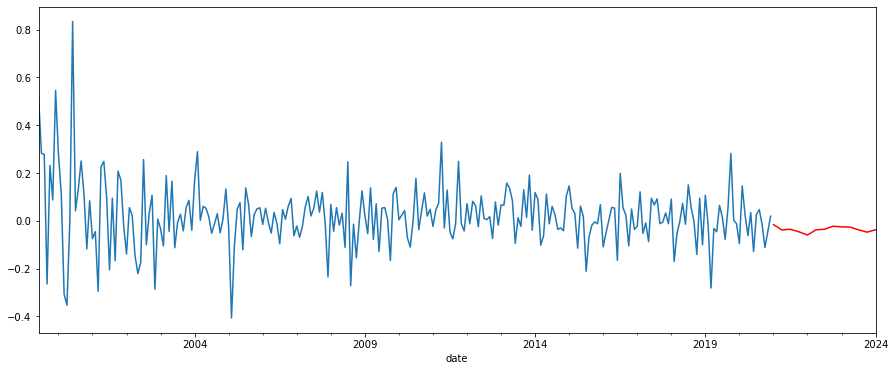

In [695]:
#set figure size
plt.figure(figsize=(15,6))
wrds_data["BIIB"].plot()
stock_data_forecast[2].plot(color='red')

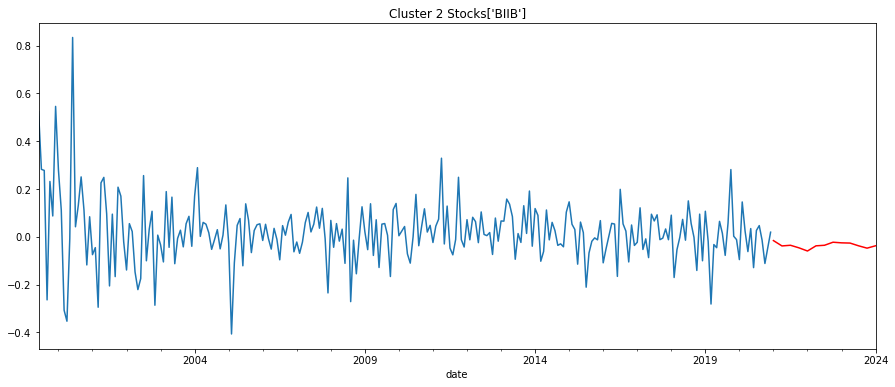

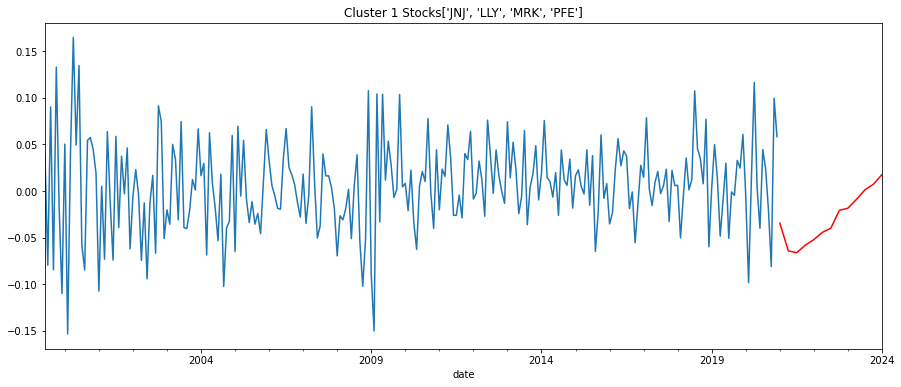

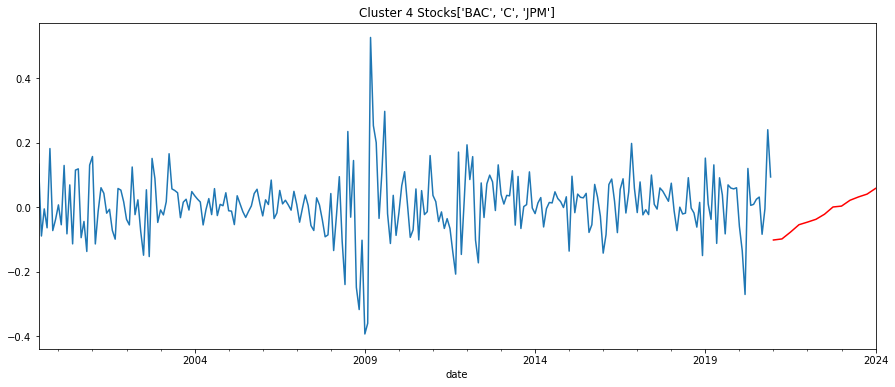

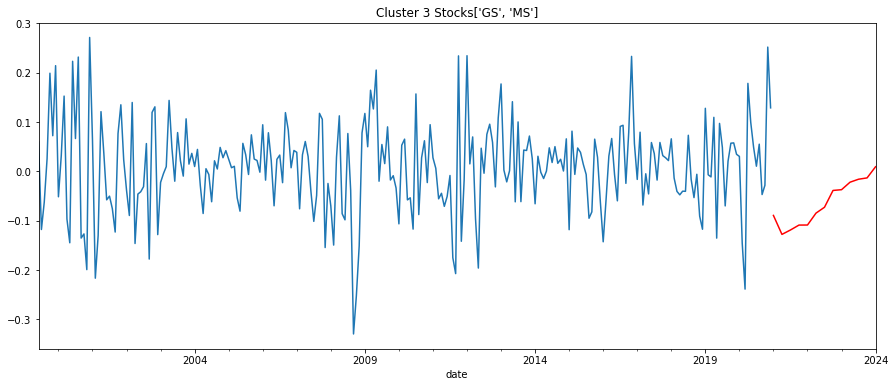

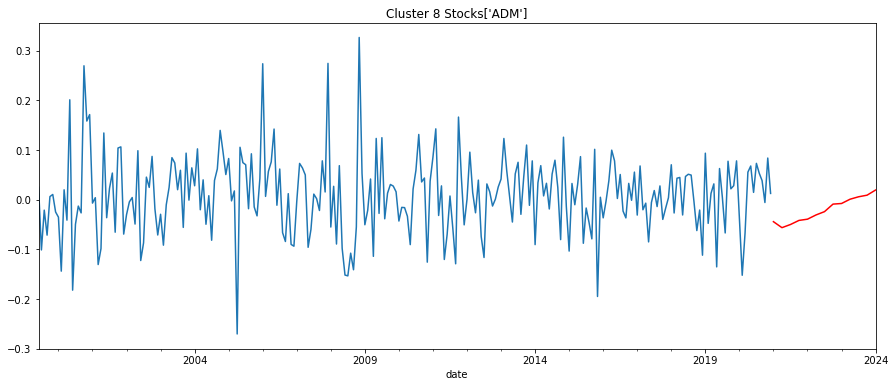

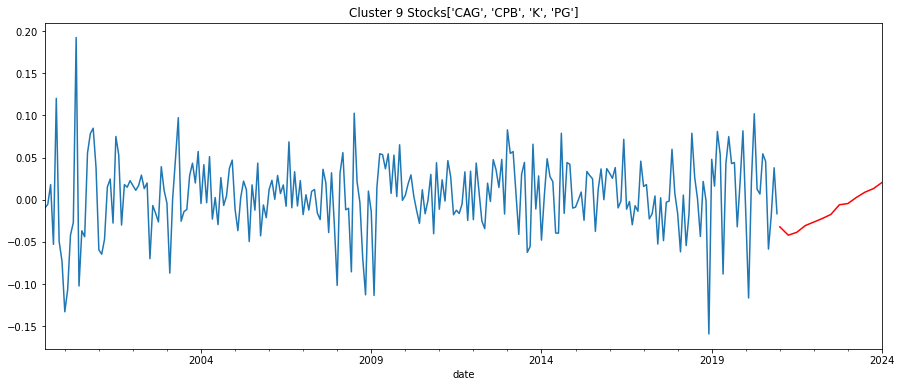

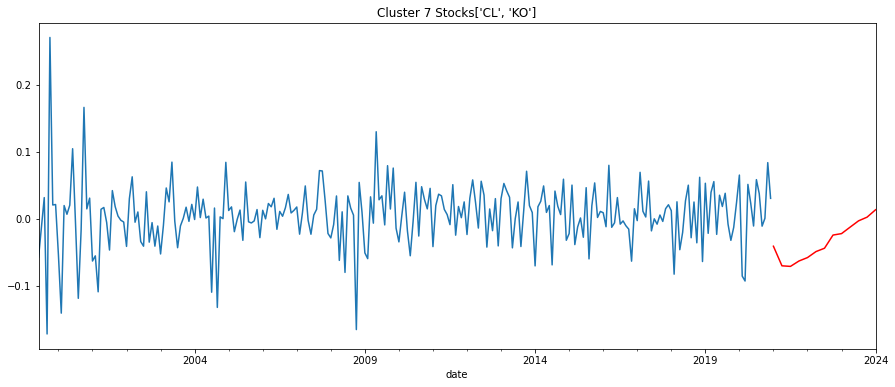

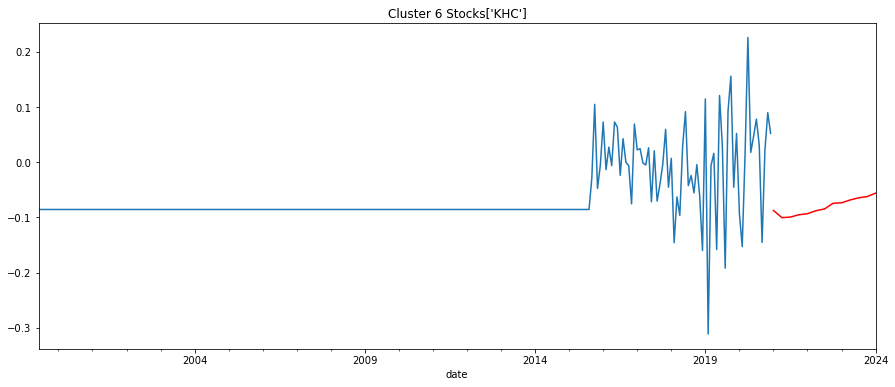

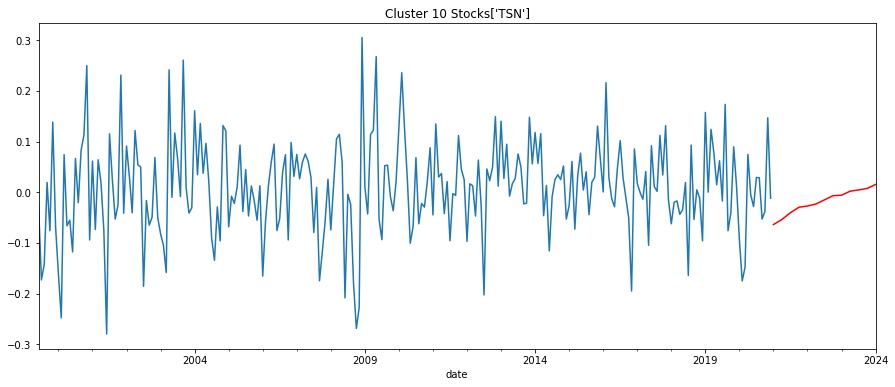

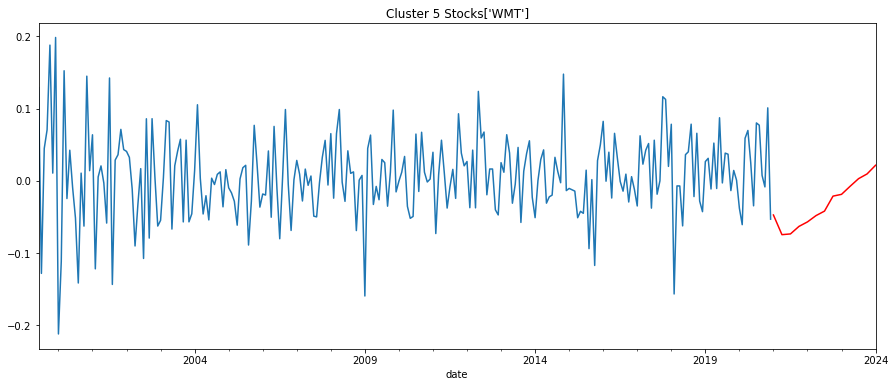

In [705]:
#Loop through and plot the stocks in each cluster, make sure to take the mean of the stocks in each cluster
for cluster,stocks in grouped_stocks.items():
    plt.figure(figsize=(15,6))
    wrds_data[stocks].mean(axis=1).plot()
    stock_data_forecast[cluster].plot(color='red')
    plt.title('Cluster '+str(cluster)+' Stocks'+str(stocks))
    plt.show()

## MULTI FACTOR MODEL PREDICTION

In [697]:
X = df_mev
lr = LinearRegression()
stock_data_forecast_MMF = pd.DataFrame(index=ff_data_forecast.index)
for cluster,stocks in grouped_stocks.items():
    stock_data_forecast_MMF[cluster] = wrds_data_q[stocks].mean(axis=1)
for cluster,stocks in grouped_stocks.items():
    #Run a OLS regression for each cluster against the market (column 1 of ff_data)
    y = wrds_data_q[stocks].mean(axis=1)
    lr.fit(X, y)
    stock_data_forecast_MMF[cluster] = lr.predict(sm.add_constant(scenario))  

In [698]:
stock_data_forecast_MMF

,2,1,4,3,8,9,7,6,10,5
date,,,,,,,,,,
2021-01-01,-0.010,0.054,-0.111,-0.097,0.004,-0.079,-0.069,0.026,-0.142,-0.124
2021-04-01,0.066,0.023,-0.120,-0.072,0.022,-0.053,-0.069,-0.006,-0.151,-0.201
2021-07-01,0.015,0.020,-0.113,-0.064,0.027,-0.060,-0.085,-0.003,-0.113,-0.203
2021-10-01,-0.073,0.027,-0.117,-0.049,0.049,-0.061,-0.089,-0.009,-0.107,-0.172
2022-01-01,-0.119,0.043,-0.113,-0.062,0.048,-0.072,-0.099,-0.014,-0.125,-0.147
2022-04-01,-0.120,0.047,-0.097,-0.079,0.052,-0.065,-0.076,-0.019,-0.077,-0.144
2022-07-01,-0.112,0.060,-0.078,-0.106,0.060,-0.067,-0.071,-0.024,-0.053,-0.134
2022-10-01,-0.204,0.058,-0.094,-0.092,0.140,-0.070,-0.052,-0.032,-0.023,-0.073
2023-01-01,-0.170,0.064,-0.066,-0.110,0.146,-0.086,-0.055,-0.025,-0.030,-0.049


### We are plotting a sample forecast for BIIB below. Other plots maybe constructed in a similar manner.

<AxesSubplot:xlabel='date'>

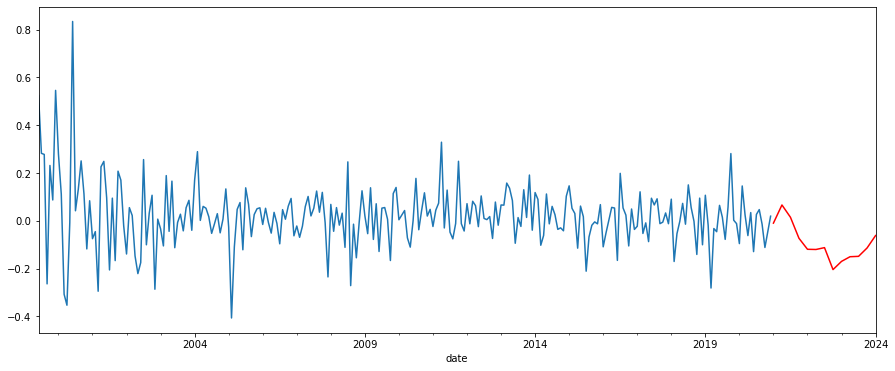

In [699]:
#set figure size
plt.figure(figsize=(15,6))
wrds_data["BIIB"].plot()
stock_data_forecast_MMF[2].plot(color='red')

### Oberservations
> The severity of the stressed scenario is apparent from the predictions as we see much lower predicted returns.
>
> This shows some success on the relatively basic linear regression models we have run to model our various clusters.